#symmetry detection Workflow for  Medical images

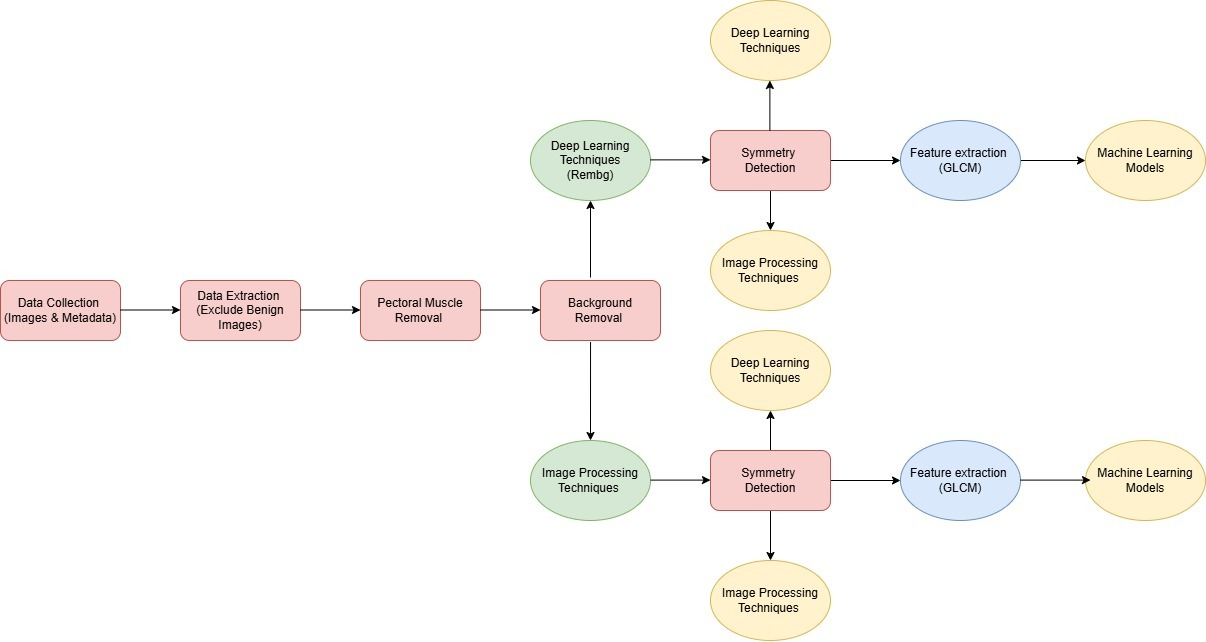

In [ ]:
from google.colab import drive
# Check if the mountpoint exists and is not empty, then remove its contents
mountpoint = '/content/drive'
drive.mount(mountpoint)

Mounted at /content/drive


In [ ]:
pip install rembg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 4.3 MB/s eta 0:00:00


In [ ]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.4 MB/s eta 0:00:00


In [ ]:
# @title Load the required libraries
import cv2
import numpy as np
import math
import os
from skimage import morphology
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.feature import canny
from skimage.filters import sobel
from skimage.transform import hough_line, hough_line_peaks
from skimage.draw import polygon
from skimage.morphology import binary_dilation, disk
from scipy.ndimage import convolve, gaussian_filter1d, rotate
from skimage.measure import find_contours, label, regionprops
from scipy.fft import fft2
import shutil
from collections import defaultdict
from numba import jit
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from imblearn.over_sampling import SMOTE
from skimage.feature import graycomatrix, graycoprops
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTETomek,SMOTEENN
from sklearn.metrics import roc_curve, confusion_matrix, classification_report
import seaborn as sns
from sklearn.linear_model import LogisticRegression



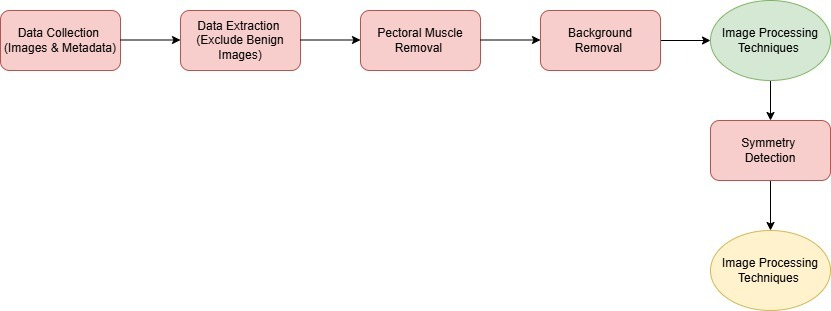

In [ ]:
# @title prctoral_muscle_Removal
def create_output_folder(input_folder):
    output_folder = "/content/drive/MyDrive/image_symmetry_project/pectoral_muscle_removal"
    # os.path.join(os.path.dirname(input_folder), "esraa_pectoral")
    os.makedirs(output_folder, exist_ok=True)
    return output_folder

def right_orient_mammogram(image):
    _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY)
    left_nonzero = cv2.countNonZero(thresh[:, :image.shape[1] // 2])
    right_nonzero = cv2.countNonZero(thresh[:, image.shape[1] // 2:])
    if left_nonzero < right_nonzero:
        image = cv2.flip(image, 1)
    return image

def resize_to_match(image, reference_image):
    if image.shape != reference_image.shape:
        image = cv2.resize(image, (reference_image.shape[1], reference_image.shape[0]))
    return image

def preprocess_image(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY_INV, 11, 2)
    return image

def read_image(filename):
    image = io.imread(filename)
    if len(image.shape) > 2:
        image = color.rgb2gray(image)
    image = (image * 255).astype(np.uint8)
    return image

def apply_canny(image):
    image = binary_dilation(image, disk(3))
    edges = canny(image, sigma=3.0)
    return sobel(edges)

def get_hough_lines(edge_img):
    h, theta, d = hough_line(edge_img, theta=np.linspace(-np.pi / 2, np.pi / 2, 180))  # Increase angular resolution if needed
    lines = []
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d, threshold=10, min_distance=50)):  # Adjust threshold and min_distance
        if abs(np.sin(angle)) < 0.1:
            continue
        x1, x2 = 0, edge_img.shape[1]
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
        y1 = np.clip(y1, 0, edge_img.shape[0]-1)
        y2 = np.clip(y2, 0, edge_img.shape[0]-1)
        lines.append({'dist': dist, 'angle': np.degrees(angle), 'point1': [x1, y1], 'point2': [x2, y2]})
    return lines

def shortlist_lines(lines, shape):
    height, width = shape
    MIN_ANGLE, MAX_ANGLE = 10, 80  # Narrow down the angle range
    MIN_DIST, MAX_DIST = 0.2 * width, 0.9 * width  # Adjust distance range
    return [x for x in lines if MIN_DIST <= x['dist'] <= MAX_DIST and MIN_ANGLE <= x['angle'] <= MAX_ANGLE]

def select_pectoral_line(lines, shape):
    if not lines:
        return None
    width = shape[1]
    best_score = float('inf')
    best_line = None
    for line in lines:
        angle_score = abs(line['angle'] - 30)  # Target angle can be adjusted
        dist_score = abs(line['dist'] / width - 0.6)  # Normalize distance to center
        score = angle_score + dist_score * 50  # Weight distance more heavily
        if score < best_score:
            best_score = score
            best_line = line
    return best_line

def remove_pectoral(image, line):
    if not line:
        return image
    d = line['dist']
    theta = np.radians(line['angle'])
    x_intercept = d / np.cos(theta)
    y_intercept = d / np.sin(theta)
    x_intercept = np.clip(x_intercept, 0, image.shape[1])
    y_intercept = np.clip(y_intercept, 0, image.shape[0])
    rr, cc = polygon([0, 0, y_intercept], [0, x_intercept, 0], shape=image.shape)
    mask = np.ones_like(image)
    mask[rr, cc] = 0
    return image * mask

def process_image(path, output_folder, reference_image=None):
    image = read_image(path)
    image = right_orient_mammogram(image)
    if reference_image is not None:
        image = resize_to_match(image, reference_image)
    else:
        reference_image = image.copy()
    original = image.copy()
    preprocessed = preprocess_image(image)
    edges = apply_canny(preprocessed)
    lines = get_hough_lines(edges)
    shortlisted = shortlist_lines(lines, image.shape)
    best_line = select_pectoral_line(shortlisted, image.shape)
    result = remove_pectoral(original, best_line)
    filename = os.path.basename(path)
    io.imsave(os.path.join(output_folder, f"{filename}"), result)
    return reference_image

def process_mlo_images(input_folder):
    output_folder = create_output_folder(input_folder)
    print(f"Saving results to: {output_folder}")
    image_paths = [
        os.path.join(root, file)
        for root, _, files in os.walk(input_folder)
        for file in files
        if "mlo" in file.lower() and file.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    print(f"Found {len(image_paths)} MLO images.")
    reference_image = None
    for i, path in enumerate(image_paths, 1):
        print(f"\n[{i}/{len(image_paths)}] Processing {os.path.basename(path)}")
        result = process_image(path, output_folder, reference_image)
        if reference_image is None:
            reference_image = result
    print("\n✅ All images processed.")

if __name__ == "__main__":
    input_folder = "/content/drive/MyDrive/Image_processing_project/Low energy images of CDD-CESM"
    process_mlo_images(input_folder)


Saving results to: /content/drive/MyDrive/image_symmetry_project/pectoral_muscle_removal
Found 503 MLO images.

[1/503] Processing P101_R_DM_MLO.jpg

[2/503] Processing P100_R_DM_MLO.jpg

[3/503] Processing P101_L_DM_MLO.jpg

[4/503] Processing P103_L_DM_MLO.jpg

[5/503] Processing P102_R_DM_MLO.jpg

[6/503] Processing P102_L_DM_MLO.jpg

[7/503] Processing P104_L_DM_MLO.jpg

[8/503] Processing P103_R_DM_MLO.jpg

[9/503] Processing P105_R_DM_MLO.jpg

[10/503] Processing P107_R_DM_MLO.jpg

[11/503] Processing P105_L_DM_MLO.jpg

[12/503] Processing P106_L_DM_MLO.jpg

[13/503] Processing P10_L_DM_MLO.jpg

[14/503] Processing P110_R_DM_MLO.jpg

[15/503] Processing P10_R_DM_MLO.jpg

[16/503] Processing P111_R_DM_MLO.jpg

[17/503] Processing P111_L_DM_MLO.jpg

[18/503] Processing P110_L_DM_MLO.jpg

[19/503] Processing P11_R_DM_MLO.jpg

[20/503] Processing P113_L_DM_MLO.jpg

[21/503] Processing P118_R_DM_MLO.jpg

[22/503] Processing P120_L_DM_MLO.jpg


KeyboardInterrupt: 

In [ ]:
# @title images_without_pectoral(_CC.jpg)


# Define the source and destination paths
source_folder = "/content/drive/MyDrive/Image_processing_project/Low energy images of CDD-CESM"
destination_folder = "/content/drive/MyDrive/image_symmetry_project/Only_CC_view_images"

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Loop through files in the source folder
for filename in os.listdir(source_folder):
    if "_CC" in filename and filename.lower().endswith((".jpg", ".jpeg", ".png")):
        source_path = os.path.join(source_folder, filename)
        destination_path = os.path.join(destination_folder, filename)
        shutil.copy2(source_path, destination_path)

print("Only '_CC' images copied successfully.")


Only '_CC' images copied successfully.


In [ ]:
import os

destination_folder = "/content/drive/MyDrive/image_symmetry_project/Only_CC_view_images"
# Count only image files with typical extensions
image_extensions = (".jpg", ".jpeg", ".png")

image_files = [f for f in os.listdir(destination_folder) if f.lower().endswith(image_extensions)]
count = len(image_files)

print(f"Number of image files in '{destination_folder}': {count}")


Number of image files in '/content/drive/MyDrive/image_symmetry_project/Only_CC_view_images': 500


In [ ]:
# @title Final dataset

# Paths to the source folders
folder1 = "/content/drive/MyDrive/image_symmetry_project/pectoral_muscle_removal"
folder2 = "/content/drive/MyDrive/image_symmetry_project/Only_CC_view_images"

# Path to the destination folder
combined_folder = "/content/drive/MyDrive/image_symmetry_project/Combined_images"

# Create the destination folder if it doesn't exist
os.makedirs(combined_folder, exist_ok=True)

# Function to copy images from a folder to the destination
def copy_images(src_folder):
    for filename in os.listdir(src_folder):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            src_path = os.path.join(src_folder, filename)
            dst_path = os.path.join(combined_folder, filename)

            # If filename already exists, avoid overwriting by renaming
            if os.path.exists(dst_path):
                base, ext = os.path.splitext(filename)
                count = 1
                while os.path.exists(dst_path):
                    dst_path = os.path.join(combined_folder, f"{base}_{count}{ext}")
                    count += 1

            shutil.copy2(src_path, dst_path)

# Copy images from both folders
copy_images(folder1)
copy_images(folder2)

print("Images from both folders have been combined successfully.")


Images from both folders have been combined successfully.


In [ ]:
# @title Get_pairs


# Source folder with all images
source_folder = "/content/drive/MyDrive/image_symmetry_project/Combined_images"
# Destination folder to save only paired images
destination_folder = "/content/drive/MyDrive/image_symmetry_project/paired_images"

os.makedirs(destination_folder, exist_ok=True)

# Dictionary to store images by key: (ID, View)
images = {}

# Step 1: Index images
for filename in os.listdir(source_folder):
    if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    parts = filename.split("_")
    if len(parts) < 4:
        continue  # skip improperly named files

    image_id = parts[0]  # e.g., P101
    side = parts[1]      # L or R
    view = parts[-1].split(".")[0]  # e.g., MLO or CC

    key = (image_id, view)

    if key not in images:
        images[key] = {}

    images[key][side] = filename

# Step 2: Copy only pairs to the destination
for (image_id, view), sides in images.items():
    if "L" in sides and "R" in sides:
        for side in ["L", "R"]:
            src_path = os.path.join(source_folder, sides[side])
            dst_path = os.path.join(destination_folder, sides[side])
            shutil.copy2(src_path, dst_path)

print("Paired left-right images successfully copied.")


Paired left-right images successfully copied.


In [ ]:
import os

destination_folder = "/content/drive/MyDrive/image_symmetry_project/paired_images"

# Count only image files with typical extensions
image_extensions = (".jpg", ".jpeg", ".png")

image_files = [f for f in os.listdir(destination_folder) if f.lower().endswith(image_extensions)]
count = len(image_files)

print(f"Number of image files in '{destination_folder}': {count}")


Number of image files in '/content/drive/MyDrive/image_symmetry_project/paired_images': 430


In [ ]:
# @title Remove background
def create_ball_kernel(radius):
    """Create a ball-shaped kernel for morphological operations"""
    diameter = 2 * radius + 1
    kernel = np.zeros((diameter, diameter))
    for i in range(diameter):
        for j in range(diameter):
            distance = math.sqrt((i - radius)**2 + (j - radius)**2)
            if distance <= radius:
                kernel[i, j] = 1
    return kernel.astype(np.uint8)

def rolling_ball_background_subtraction(image, ball_radius=5):
    """Implement rolling ball background subtraction"""
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    ball = create_ball_kernel(ball_radius)
    background = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, ball)
    subtracted = cv2.subtract(gray, background)
    return cv2.normalize(subtracted, None, 0, 255, cv2.NORM_MINMAX)

def huang_fuzzy_threshold(image):
    """Implement Huang's fuzzy thresholding algorithm"""
    hist = cv2.calcHist([image], [0], None, [256], [0, 256]).ravel()
    total_pixels = image.size
    min_entropy = float('inf')
    optimal_threshold = 0

    for threshold in range(1, 255):
        w0 = np.sum(hist[:threshold]) / total_pixels
        w1 = 1 - w0

        entropy = 0
        for i in range(256):
            if i < threshold:
                mu = i / threshold
            else:
                mu = (i - threshold) / (255 - threshold)

            if 0 < mu < 1:
                entropy += hist[i] * (-mu * math.log(mu) - (1 - mu) * math.log(1 - mu))

        if entropy < min_entropy:
            min_entropy = entropy
            optimal_threshold = threshold

    return optimal_threshold

def morphological_cleanup(binary_image):
    """Clean up binary image with morphological operations"""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    cleaned = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
    return morphology.remove_small_holes(cleaned.astype(bool), area_threshold=500).astype(np.uint8) * 255

def create_white_background_result(original, mask):
    """Create result with white background"""
    white_bg = np.full_like(original, 255)
    return np.where(mask[:, :, None].astype(bool), original, white_bg)

def visualize_results(original, subtracted, binary, final_mask, result):
    """Visualize all processing steps"""
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(subtracted, cmap='gray')
    plt.title('After Background Subtraction')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(binary, cmap='gray')
    plt.title('Binary Threshold')
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(final_mask, cmap='gray')
    plt.title('After Morphological Cleaning')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title('Final Result')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def process_single_image(image_path, output_path=None, visualize=True):
    """Process a single image through the pipeline"""
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image from path: {image_path}")

    subtracted = rolling_ball_background_subtraction(img)
    threshold = huang_fuzzy_threshold(subtracted)
    _, binary = cv2.threshold(subtracted, threshold, 255, cv2.THRESH_BINARY)
    final_mask = morphological_cleanup(binary)
    result = create_white_background_result(img, final_mask)

    if visualize:
        visualize_results(img, subtracted, binary, final_mask, result)

    if output_path:
        cv2.imwrite(output_path, result)

    return result

def process_folder(input_folder, output_folder, visualize=False):
    """Process all images in a folder"""
    os.makedirs(output_folder, exist_ok=True)

    supported_formats = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
    image_files = [f for f in os.listdir(input_folder)
                 if f.lower().endswith(supported_formats)]

    for image_file in image_files:
        input_path = os.path.join(input_folder, image_file)
        output_path = os.path.join(output_folder, image_file)

        try:
            print(f"Processing: {image_file}")
            process_single_image(input_path, output_path, visualize)
            print(f"Saved to: {output_path}")
        except Exception as e:
            print(f"Error processing {image_file}: {str(e)}")

if __name__ == "__main__":
    # Example usage modes:

    # 1. Process a single image with visualization
    # result = process_single_image("input.jpg", "output.jpg", visualize=True)

    # 2. Process a folder of images
    input_folder = "/content/drive/MyDrive/image_symmetry_project/paired_images"
    output_folder = "/content/drive/MyDrive/image_symmetry_project/Background_removal"
    process_folder(input_folder, output_folder)

Processing: P101_L_DM_MLO.jpg
Saved to: /content/drive/MyDrive/image_symmetry_project/Background_removal/P101_L_DM_MLO.jpg
Processing: P101_R_DM_MLO.jpg
Saved to: /content/drive/MyDrive/image_symmetry_project/Background_removal/P101_R_DM_MLO.jpg
Processing: P103_L_DM_MLO.jpg
Saved to: /content/drive/MyDrive/image_symmetry_project/Background_removal/P103_L_DM_MLO.jpg
Processing: P103_R_DM_MLO.jpg
Saved to: /content/drive/MyDrive/image_symmetry_project/Background_removal/P103_R_DM_MLO.jpg
Processing: P102_L_DM_MLO.jpg
Saved to: /content/drive/MyDrive/image_symmetry_project/Background_removal/P102_L_DM_MLO.jpg
Processing: P102_R_DM_MLO.jpg
Saved to: /content/drive/MyDrive/image_symmetry_project/Background_removal/P102_R_DM_MLO.jpg
Processing: P105_L_DM_MLO.jpg
Saved to: /content/drive/MyDrive/image_symmetry_project/Background_removal/P105_L_DM_MLO.jpg
Processing: P105_R_DM_MLO.jpg
Saved to: /content/drive/MyDrive/image_symmetry_project/Background_removal/P105_R_DM_MLO.jpg
Processing: P10_

In [ ]:
# @title symmetry detection:

from scipy.ndimage import convolve, gaussian_filter1d, rotate
from skimage.measure import find_contours, label, regionprops
import matplotlib.pyplot as plt
from numba import jit
from joblib import Parallel, delayed

def load_images(left_path, right_path):
    if not (os.path.exists(left_path) and os.path.exists(right_path)):
        raise FileNotFoundError(f"One or both image files not found: {left_path}, {right_path}")
    left_img = cv2.imread(left_path, cv2.IMREAD_GRAYSCALE)
    right_img = cv2.imread(right_path, cv2.IMREAD_GRAYSCALE)
    if left_img is None or right_img is None:
        raise ValueError("Failed to load one or both images.")
    if len(np.unique(left_img)) <= 2 and len(np.unique(right_img)) <= 2:
        print(f"Images {os.path.basename(left_path)} and {os.path.basename(right_path)} are already binary, skipping thresholding.")
    else:
        left_img = cv2.adaptiveThreshold(left_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY, 11, 2)
        right_img = cv2.adaptiveThreshold(right_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY, 11, 2)
    left_img = cv2.GaussianBlur(left_img, (3, 3), 0)
    right_img = cv2.GaussianBlur(right_img, (3, 3), 0)
    return left_img, right_img

def extract_control_points(img, sigma=15):
    try:
        mask = img > 0
        moments = cv2.moments(mask.astype(np.uint8))
        if moments['m00'] == 0:
            raise ValueError("Cannot compute center of mass.")
        center_mass = np.array([moments['m10'] / moments['m00'], moments['m01'] / moments['m00']])

        contours = find_contours(img, level=0.5)
        if not contours:
            raise ValueError("No contours found.")
        contour = max(contours, key=len)
        smoothed_x = gaussian_filter1d(contour[:, 1], sigma)
        smoothed_y = gaussian_filter1d(contour[:, 0], sigma)
        smoothed_contour = np.vstack((smoothed_y, smoothed_x)).T

        distances = np.linalg.norm(smoothed_contour - center_mass, axis=1)
        nipple_idx = np.argmax(distances)
        nipple = smoothed_contour[nipple_idx]

        left_edge_dist = smoothed_contour[:, 1]
        right_edge_dist = img.shape[1] - smoothed_contour[:, 1]
        left_corner_idx = np.argmin(left_edge_dist)
        right_corner_idx = np.argmin(right_edge_dist)
        corners = np.array([smoothed_contour[left_corner_idx], smoothed_contour[right_corner_idx]])
        return nipple, corners, mask, moments
    except Exception as e:
        print(f"Contour-based control point extraction failed: {e}. Using bounding box fallback.")
        mask = img > 0
        coords = np.where(mask)
        if not coords[0].size:
            raise ValueError("No non-zero pixels found in image.")
        top, bottom = np.min(coords[0]), np.max(coords[0])
        left, right = np.min(coords[1]), np.max(coords[1])
        nipple = np.array([(top + bottom) / 2, right])
        corners = np.array([[top, left], [bottom, left]])
        moments = cv2.moments(mask.astype(np.uint8))
        return nipple, corners, mask, moments

def align_images(left_img, right_img, left_control_points, right_control_points):
    try:
        if left_control_points is None or right_control_points is None:
            raise ValueError("Control points are None, using center-of-mass alignment.")
        nipple_left, corners_left, mask_left, moments_left = left_control_points
        nipple_right, corners_right, mask_right, moments_right = right_control_points
        C1_left, C3_left = corners_left
        C1_right, C3_right = corners_right
        C_m_left = (C1_left + C3_left) / 2
        C_m_right = (C1_right + C3_right) / 2
        baseline_left = C3_left - C1_left
        angle_left = np.arctan2(baseline_left[0], baseline_left[1]) * 180 / np.pi
        baseline_right = C3_right - C1_right
        angle_right = np.arctan2(baseline_right[0], baseline_right[1]) * 180 / np.pi
        rotation_angle = angle_left - angle_right

        right_img_rotated = rotate(right_img, rotation_angle, reshape=True, mode='nearest')
        right_img_rotated_binary = (right_img_rotated > 0).astype(np.uint8) * 255
        nipple_right_rot, corners_right_rot, _, _ = extract_control_points(right_img_rotated_binary)
        C_m_right_rot = (corners_right_rot[0] + corners_right_rot[1]) / 2
        translation = C_m_left - C_m_right_rot

        right_img_translated = np.roll(right_img_rotated, int(translation[0]), axis=0)
        right_img_translated = np.roll(right_img_translated, int(translation[1]), axis=1)

        h_left = np.linalg.norm(nipple_left - C_m_left)
        h_right = np.linalg.norm(nipple_right_rot - C_m_right_rot)
        scale_factor = h_left / (h_right + 1e-10)

        right_img_scaled = cv2.resize(right_img_translated, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_NEAREST)
        right_img_aligned = cv2.resize(right_img_scaled, (left_img.shape[1], left_img.shape[0]), interpolation=cv2.INTER_NEAREST)
        return right_img_aligned, False
    except Exception as e:
        print(f"Control point alignment failed: {e}. Using center-of-mass alignment.")
        mask_left = left_img > 0
        mask_right = right_img > 0
        moments_left = cv2.moments(mask_left.astype(np.uint8))
        moments_right = cv2.moments(mask_right.astype(np.uint8))
        if moments_left['m00'] == 0 or moments_right['m00'] == 0:
            raise ValueError("Cannot compute center of mass for one or both images.")
        center_left = np.array([moments_left['m10'] / moments_left['m00'], moments_left['m01'] / moments_left['m00']])
        center_right = np.array([moments_right['m10'] / moments_right['m00'], moments_right['m01'] / moments_right['m00']])
        translation = center_left - center_right
        right_img_translated = np.roll(right_img, int(translation[0]), axis=0)
        right_img_translated = np.roll(right_img_translated, int(translation[1]), axis=1)
        right_img_aligned = cv2.resize(right_img_translated, (left_img.shape[1], left_img.shape[0]), interpolation=cv2.INTER_NEAREST)
        return right_img_aligned, True

def normalize_image(img, mask=None):
    if mask is None:
        mask = img > 0
    mean = np.mean(img[mask]) if np.any(mask) else 0
    std = np.std(img[mask]) if np.any(mask) else 1
    normalized = np.zeros_like(img, dtype=np.float32)
    normalized[mask] = (img[mask] - mean) / (std + 1e-10)
    return normalized, mask

@jit(nopython=True)
def compute_window_stats(window, n):
    h_diff = np.abs(window[:, 1:] - window[:, :-1])
    v_diff = np.abs(window[1:, :] - window[:-1, :])
    diff = np.concatenate((h_diff.ravel(), v_diff.ravel()))
    hist, _ = np.histogram(diff, bins=256, range=(0, 255))
    p_j = hist / (n * n)
    sigma = np.sum(np.arange(256)**2 * p_j)

    total = 0.0
    count = 0
    for i in range(window.shape[0]):
        for j in range(window.shape[1]):
            if window[i, j] > 0:
                total += window[i, j]
                count += 1
    mu = total / count if count > 0 else 0.0
    return sigma, mu

def brightness_to_roughness(img, window_size=15):
    n = window_size
    sigma_W = np.zeros_like(img, dtype=np.float32)
    mu_W = np.zeros_like(img, dtype=np.float32)

    from numpy.lib.stride_tricks import sliding_window_view
    windows = sliding_window_view(img, (n, n))
    h, w = windows.shape[:2]

    def process_window(i, j):
        window = windows[i, j]
        if np.any(window > 0):
            sigma, mu = compute_window_stats(window, n)
            return i + n//2, j + n//2, sigma, mu
        return None

    results = Parallel(n_jobs=-1)(
        delayed(process_window)(i, j) for i in range(h) for j in range(w)
    )

    for result in results:
        if result is not None:
            i, j, sigma, mu = result
            sigma_W[i, j] = sigma
            mu_W[i, j] = mu

    q = mu_W**2 / (1 + sigma_W + 1e-10)
    return q

def brightness_difference(left_img, right_img, kernel_size=3):
    if left_img.shape != right_img.shape:
        raise ValueError(f"Image shapes mismatch: {left_img.shape} vs {right_img.shape}")
    kernel = np.ones((kernel_size, kernel_size), dtype=np.float32) / (kernel_size ** 2)
    conv_left = convolve(left_img, kernel, mode='constant')
    conv_right = convolve(right_img, kernel, mode='constant')
    B = np.abs(conv_left - conv_right)
    B = (B - np.min(B)) / (np.max(B) - np.min(B) + 1e-10)
    print(f"Debug: Mean Brightness Difference (B): {np.mean(B[B > 0]):.3f}")
    return B

def local_variance(img, var_size=15, norm_size=31):
    kernel_var = np.ones((var_size, var_size), dtype=np.float32)
    kernel_norm = np.ones((norm_size, norm_size), dtype=np.float32)

    img_sq = img**2
    conv_img_var = convolve(img, kernel_var, mode='constant')
    conv_img_sq_var = convolve(img_sq, kernel_var, mode='constant')
    conv_img_norm = convolve(img, kernel_norm, mode='constant')
    conv_img_sq_norm = convolve(img_sq, kernel_norm, mode='constant')

    var = conv_img_sq_var - conv_img_var**2 / (var_size**2)
    norm = conv_img_sq_norm - conv_img_norm**2 / (norm_size**2)

    result = var / (norm + 1e-10)
    print(f"Debug: Mean Local Variance: {np.mean(result[result > 0]):.3f}")
    return result

def brightness_to_roughness_difference(left_img, right_img):
    q_left = brightness_to_roughness(left_img)
    q_right = brightness_to_roughness(right_img)
    Q = np.abs(q_left - q_right)
    Q = (Q - np.min(Q)) / (np.max(Q) - np.min(Q) + 1e-10)
    print(f"Debug: Mean Brightness-to-Roughness Difference (Q): {np.mean(Q[Q > 0]):.3f}")
    return Q

def roughness_difference(left_img, right_img):
    v_left = local_variance(left_img)
    v_right = local_variance(right_img)
    R = np.abs(v_left - v_right)
    R = (R - np.min(R)) / (np.max(R) - np.min(R) + 1e-10)
    print(f"Debug: Mean Roughness Difference (R): {np.mean(R[R > 0]):.3f}")
    return R

def combine_asymmetry_measures(B, R, Q, D_left=None, D_right=None):
    A = B + R + Q
    print(f"Debug: Mean Combined Asymmetry (A): {np.mean(A[A > 0]):.3f}")
    return A

def detect_suspicious_areas(A, q1=1, q2=0.95, min_area=300, radius=20):
    T1 = np.percentile(A[A > 0], 100 - q1) if np.any(A > 0) else 0
    print(f"Debug: T1 Threshold: {T1:.3f}")
    potential_areas = A > T1
    labeled = label(potential_areas)
    regions = regionprops(labeled)
    suspicious_areas = []
    for region in regions:
        if region.area > min_area:
            centroid = region.centroid
            y, x = np.ogrid[:A.shape[0], :A.shape[1]]
            mask = (x - centroid[1])**2 + (y - centroid[0])**2 <= radius**2
            mean_response = np.mean(A[mask])
            suspicious_areas.append((centroid, mean_response))
    if not suspicious_areas:
        return []
    A_max = max([area[1] for area in suspicious_areas])
    final_areas = [area for area in suspicious_areas if area[1] > q2 * A_max]
    print(f"Debug: Number of Suspicious Areas: {len(final_areas)}")
    return final_areas

def analyze_symmetry(A, suspicious_areas, alignment_failed):
    mask = A > 0
    mean_asymmetry = np.mean(A[mask]) if np.any(mask) else 0
    symmetry_threshold = 0.3
    print("\nSymmetry Analysis:")
    if suspicious_areas:
        print("The breast images are asymmetric.")
        print("Reason(s):")
        print("- Suspicious areas were detected ({} areas), indicating a potential mass in one breast.".format(len(suspicious_areas)))
        if mean_asymmetry >= symmetry_threshold:
            print("- The average asymmetry measure is high (mean A = {:.3f}), suggesting significant differences in brightness, roughness, or texture.".format(mean_asymmetry))
        if alignment_failed:
            print("- Alignment issues were detected, which may contribute to the observed asymmetry.")
        return "asymmetric"
    else:
        print("The breast images are symmetric.")
        print("Reason: No suspicious areas were detected, indicating no mass in either breast.")
        if mean_asymmetry >= symmetry_threshold:
            print("Note: The average asymmetry measure is relatively high (mean A = {:.3f}), which may suggest minor differences due to natural variations or alignment issues, but no significant mass was detected.".format(mean_asymmetry))
        if alignment_failed:
            print("Note: Alignment issues were detected, which may create minor artificial differences, but no significant mass was detected.")
        return "symmetric"

def process_image_pair(left_path, right_path, output_dir):
    alignment_failed = False
    left_img, right_img = None, None
    try:
        left_img, right_img = load_images(left_path, right_path)
        nipple_left, corners_left, mask_left, moments_left = extract_control_points(left_img)
        nipple_right, corners_right, mask_right, moments_right = extract_control_points(right_img)
    except (FileNotFoundError, ValueError) as e:
        print(f"Error processing {os.path.basename(left_path)} and {os.path.basename(right_path)}: {e}")
        if left_img is None or right_img is None:
            print("Cannot proceed without valid images.")
            return None
        print("Using center-of-mass alignment due to control point extraction failure.")
        nipple_left, corners_left, mask_left, moments_left = None, None, None, None
        nipple_right, corners_right, mask_right, moments_right = None, None, None, None
        alignment_failed = True

    right_img_aligned, alignment_failed = align_images(
        left_img, right_img,
        (nipple_left, corners_left, mask_left, moments_left),
        (nipple_right, corners_right, mask_right, moments_right)
    )

    N_left, mask_left = normalize_image(left_img, mask_left)
    N_right, _ = normalize_image(right_img_aligned)
    B = brightness_difference(N_left, N_right)
    R = roughness_difference(N_left, N_right)
    Q = brightness_to_roughness_difference(N_left, N_right)
    A = combine_asymmetry_measures(B, R, Q)
    suspicious_areas = detect_suspicious_areas(A)
    symmetry_status = analyze_symmetry(A, suspicious_areas, alignment_failed)

    # Save visualization
    output_image = os.path.join(output_dir, f"asymmetry_{os.path.basename(left_path).replace('_L_', '_')}")
    plt.figure(figsize=(20, 15))
    plt.subplot(221)
    overlay = cv2.addWeighted(left_img, 0.5, right_img_aligned, 0.5, 0.0)
    plt.imshow(overlay, cmap='gray')
    plt.title('Overlay of Left and Aligned Right Breast')
    if nipple_left is not None:
        plt.plot(corners_left[:, 1], corners_left[:, 0], 'ro', label='Corners')
        plt.plot(nipple_left[1], nipple_left[0], 'bo', label='Nipple')
    plt.legend()

    plt.subplot(222)
    plt.imshow(B, cmap='hot')
    plt.title('Brightness Difference (B)')
    plt.colorbar()

    plt.subplot(223)
    plt.imshow(R, cmap='hot')
    plt.title('Roughness Difference (R)')
    plt.colorbar()

    plt.subplot(224)
    plt.imshow(A, cmap='hot')
    plt.title('Combined Asymmetry Map (A)')
    plt.colorbar()

    plt.tight_layout()
    plt.savefig(output_image)
    plt.close()

    print(f"\nProcessed {os.path.basename(left_path)} and {os.path.basename(right_path)}")
    print(f"Detected {len(suspicious_areas)} suspicious areas.")
    print(f"Average Brightness Difference: {np.mean(B[B > 0]):.3f}")
    print(f"Average Roughness Difference: {np.mean(R[R > 0]):.3f}")
    print(f"Average Combined Asymmetry: {np.mean(A[A > 0]):.3f}")

    return {
        'left': os.path.basename(left_path),
        'right': os.path.basename(right_path),
        'symmetry': symmetry_status
    }

def main(directory, output_csv, output_dir):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Find all left and right images
    left_images = glob.glob(os.path.join(directory, '*_L_DM_*.jpg'))
    results = []

    # Pair left and right images
    for left_path in left_images:
        # Extract patient ID and view (e.g., P2, CC or MLO)
        left_name = os.path.basename(left_path)
        parts = left_name.split('_')
        if len(parts) < 4:
            print(f"Skipping invalid filename: {left_name}")
            continue
        patient_id = parts[0]
        view = parts[3].replace('.jpg', '')
        right_name = left_name.replace('_L_', '_R_')
        right_path = os.path.join(directory, right_name)

        if not os.path.exists(right_path):
            print(f"Missing right image for {left_name}: {right_name}")
            continue

        print(f"\nProcessing pair: {left_name} and {right_name}")
        result = process_image_pair(left_path, right_path, output_dir)
        if result is not None:
            results.append(result)

    # Save results to CSV
    if results:
        df = pd.DataFrame(results, columns=['left', 'right', 'symmetry'])
        df.to_csv(output_csv, index=False)
        print(f"\nResults saved to {output_csv}")
        print(df)
    else:
        print("No valid image pairs processed.")

if __name__ == "__main__":
    directory = "/content/drive/MyDrive/image_symmetry_project/Background_removal"
    output_csv = "/content/drive/MyDrive/image_symmetry_project/asymmetry_results.csv"
    output_dir = "/content/drive/MyDrive/image_symmetry_project/"
    main(directory, output_csv, output_dir)

In [ ]:
# @title  symmetry_detection_updated
import os
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter1d, rotate, binary_closing, convolve
from scipy.signal import convolve2d
from skimage.measure import find_contours, label, regionprops
from scipy.interpolate import CubicSpline
import pandas as pd
import glob
from numba import jit
from joblib import Parallel, delayed
from google.colab import drive # Import drive for use in main if needed

#
@jit(nopython=True)
def compute_window_stats(window, n):
    h_diff = np.abs(window[:, 1:] - window[:, :-1])
    v_diff = np.abs(window[1:, :] - window[:-1, :])
    diff = np.concatenate((h_diff.ravel(), v_diff.ravel()))
    hist, _ = np.histogram(diff, bins=256, range=(0, 255))
    p_j = hist / (n * n)
    sigma = np.sum(np.arange(256)**2 * p_j)
    total = 0.0
    count = 0
    for i in range(window.shape[0]):
        for j in range(window.shape[1]):
            if window[i, j] > 0:
                total += window[i, j]
                count += 1
    mu = total / count if count > 0 else 0.0
    return sigma, mu

def extract_control_points(img, n=15, label="image"):
    try:
        mask = img > 0
        moments = cv2.moments(mask.astype(np.uint8))
        if moments['m00'] == 0:
            raise ValueError("Cannot compute center of mass.")
        center_mass = np.array([moments['m10'] / moments['m00'], moments['m01'] / moments['m00']])
        contours = find_contours(img, level=0.5)
        if not contours:
            raise ValueError("No contours found.")
        contour = max(contours, key=len)
        if not np.allclose(contour[0], contour[-1]):
            contour = np.vstack([contour, contour[0]])
        kernel_1d = np.ones(2*n+1) / (2*n+1)
        x_smooth = convolve2d(contour[:, 1].reshape(1, -1), kernel_1d.reshape(1, -1), mode='same')[0]
        y_smooth = convolve2d(contour[:, 0].reshape(1, -1), kernel_1d.reshape(1, -1), mode='same')[0]
        smoothed_contour = np.vstack((y_smooth, x_smooth)).T
        edges = {
            'left': np.sum(mask[:, :10]),
            'right': np.sum(mask[:, -10:]),
            'top': np.sum(mask[:10, :]),
            'bottom': np.sum(mask[-10:, :])
        }
        chest_wall_side = max(edges, key=edges.get)
        distances = np.linalg.norm(smoothed_contour - center_mass, axis=1)
        nipple_idx = np.argmax(distances)
        nipple = smoothed_contour[nipple_idx]
        if chest_wall_side in ['left', 'right']:
            x_coords = smoothed_contour[:, 1]
            if chest_wall_side == 'left':
                indices = np.argsort(x_coords)[:10]
            else:
                indices = np.argsort(-x_coords)[:10]
            y_coords = smoothed_contour[indices, 0]
            top_idx = indices[np.argmin(y_coords)]
            bottom_idx = indices[np.argmax(y_coords)]
            corners = np.array([smoothed_contour[top_idx], smoothed_contour[bottom_idx]])
        else:
            y_coords = smoothed_contour[:, 0]
            if chest_wall_side == 'top':
                indices = np.argsort(y_coords)[:10]
            else:
                indices = np.argsort(-y_coords)[:10]
            x_coords = smoothed_contour[indices, 1]
            left_idx = indices[np.argmin(x_coords)]
            right_idx = indices[np.argmax(x_coords)]
            corners = np.array([smoothed_contour[left_idx], smoothed_contour[right_idx]])
        if np.linalg.norm(corners[0] - corners[1]) < 10:
            raise ValueError("Chest wall points are too close.")
        return nipple, corners, mask, moments
    except Exception as e:
        print(f"Contour-based control point extraction failed for {label}: {e}. Using bounding box fallback.")
        mask = img > 0
        coords = np.where(mask)
        if not coords[0].size:
            raise ValueError("No non-zero pixels found in image.")
        top, bottom = np.min(coords[0]), np.max(coords[0])
        left, right = np.min(coords[1]), np.max(coords[1])
        nipple = np.array([(top + bottom) / 2, right])
        corners = np.array([[top, left], [bottom, left]])
        moments = cv2.moments(mask.astype(np.uint8))
        return nipple, corners, mask, moments

# Define align_images, normalize_image, brightness_difference, local_variance,
# brightness_to_roughness_difference, roughness_difference, combine_asymmetry_measures,
# detect_suspicious_areas, and analyze_symmetry here as they are used by process_image_pair
# and main.

# Assuming these functions are copied from the 'symmetry_deteection' cell:

def load_images(left_path, right_path):
    """Load and preprocess mammogram images, accounting for prior segmentation."""
    if not (os.path.exists(left_path) and os.path.exists(right_path)):
        raise FileNotFoundError(f"One or both image files not found: {left_path}, {right_path}")
    left_img = cv2.imread(left_path, cv2.IMREAD_GRAYSCALE)
    right_img = cv2.imread(right_path, cv2.IMREAD_GRAYSCALE)
    if left_img is None or right_img is None:
        raise ValueError("Failed to load one or both images.")

    # NEW: Check if images are already binary (from background removal)
    if len(np.unique(left_img)) <= 5 and len(np.unique(right_img)) <= 5:
        print(f"Images {os.path.basename(left_path)} and {os.path.basename(right_path)} are near-binary, skipping thresholding.")
    else:
        left_img = cv2.adaptiveThreshold(left_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY, 11, 2)
        right_img = cv2.adaptiveThreshold(right_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY, 11, 2)

    # NEW: Morphological closing to smooth contours
    left_img = binary_closing(left_img, structure=np.ones((5,5))).astype(np.uint8) * 255
    right_img = binary_closing(right_img, structure=np.ones((5,5))).astype(np.uint8) * 255

    left_img = cv2.GaussianBlur(left_img, (3, 3), 0)
    right_img = cv2.GaussianBlur(right_img, (3, 3), 0)
    return left_img, right_img

def align_images(left_img, right_img, left_control_points, right_control_points):
    try:
        if left_control_points is None or right_control_points is None:
            raise ValueError("Control points are None, using center-of-mass alignment.")
        nipple_left, corners_left, mask_left, moments_left = left_control_points
        nipple_right, corners_right, mask_right, moments_right = right_control_points
        C1_left, C3_left = corners_left
        C1_right, C3_right = corners_right
        C_m_left = (C1_left + C3_left) / 2
        C_m_right = (C1_right + C3_right) / 2
        baseline_left = C3_left - C1_left
        angle_left = np.arctan2(baseline_left[0], baseline_left[1]) * 180 / np.pi
        baseline_right = C3_right - C1_right
        angle_right = np.arctan2(baseline_right[0], baseline_right[1]) * 180 / np.pi
        rotation_angle = angle_left - angle_right

        right_img_rotated = rotate(right_img, rotation_angle, reshape=True, mode='nearest')
        right_img_rotated_binary = (right_img_rotated > 0).astype(np.uint8) * 255
        # Need to ensure extract_control_points can handle the rotated binary image
        nipple_right_rot, corners_right_rot, _, _ = extract_control_points(right_img_rotated_binary)
        C_m_right_rot = (corners_right_rot[0] + corners_right_rot[1]) / 2
        translation = C_m_left - C_m_right_rot

        # Note: np.roll might not be ideal for image translation due to wrapping edges
        # Consider using cv2.warpAffine or scipy.ndimage.shift
        # For now, keeping np.roll as in original code
        right_img_translated = np.roll(right_img_rotated, int(translation[0]), axis=0)
        right_img_translated = np.roll(right_img_translated, int(translation[1]), axis=1)

        h_left = np.linalg.norm(nipple_left - C_m_left)
        h_right = np.linalg.norm(nipple_right_rot - C_m_right_rot)
        scale_factor = h_left / (h_right + 1e-10)

        right_img_scaled = cv2.resize(right_img_translated, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_NEAREST)
        right_img_aligned = cv2.resize(right_img_scaled, (left_img.shape[1], left_img.shape[0]), interpolation=cv2.INTER_NEAREST)
        return right_img_aligned, False
    except Exception as e:
        print(f"Control point alignment failed: {e}. Using center-of-mass alignment.")
        mask_left = left_img > 0
        mask_right = right_img > 0
        moments_left = cv2.moments(mask_left.astype(np.uint8))
        moments_right = cv2.moments(mask_right.astype(np.uint8))
        if moments_left['m00'] == 0 or moments_right['m00'] == 0:
            raise ValueError("Cannot compute center of mass for one or both images.")
        center_left = np.array([moments_left['m10'] / moments_left['m00'], moments_left['m01'] / moments_left['m00']])
        center_right = np.array([moments_right['m10'] / moments_right['m00'], moments_right['m01'] / moments_right['m00']])
        translation = center_left - center_right
        # Note: np.roll might not be ideal for image translation due to wrapping edges
        # Consider using cv2.warpAffine or scipy.ndimage.shift
        # For now, keeping np.roll as in original code
        right_img_translated = np.roll(right_img, int(translation[0]), axis=0)
        right_img_translated = np.roll(right_img_translated, int(translation[1]), axis=1)
        right_img_aligned = cv2.resize(right_img_translated, (left_img.shape[1], left_img.shape[0]), interpolation=cv2.INTER_NEAREST)
        return right_img_aligned, True

def normalize_image(img, mask=None):
    if mask is None:
        mask = img > 0
    mean = np.mean(img[mask]) if np.any(mask) else 0
    std = np.std(img[mask]) if np.any(mask) else 1
    normalized = np.zeros_like(img, dtype=np.float32)
    normalized[mask] = (img[mask] - mean) / (std + 1e-10)
    return normalized, mask

def brightness_difference(left_img, right_img, kernel_size=3):
    if left_img.shape != right_img.shape:
        raise ValueError(f"Image shapes mismatch: {left_img.shape} vs {right_img.shape}")
    kernel = np.ones((kernel_size, kernel_size), dtype=np.float32) / (kernel_size ** 2)
    # Use scipy.ndimage.convolve
    conv_left = convolve(left_img, kernel, mode='constant', cval=0)
    conv_right = convolve(right_img, kernel, mode='constant', cval=0)
    B = np.abs(conv_left - conv_right)
    B = (B - np.min(B)) / (np.max(B) - np.min(B) + 1e-10)
    print(f"Debug: Mean Brightness Difference (B): {np.mean(B[B > 0]):.3f}")
    return B

def local_variance(img, var_size=15, norm_size=31):
    kernel_var = np.ones((var_size, var_size), dtype=np.float32)
    kernel_norm = np.ones((norm_size, norm_size), dtype=np.float32)
    img_sq = img**2
    # Use scipy.ndimage.convolve
    conv_img_var = convolve(img, kernel_var, mode='constant', cval=0)
    conv_img_sq_var = convolve(img_sq, kernel_var, mode='constant', cval=0)
    conv_img_norm = convolve(img, kernel_norm, mode='constant', cval=0)
    conv_img_sq_norm = convolve(img_sq, kernel_norm, mode='constant', cval=0)
    var = conv_img_sq_var - conv_img_var**2 / (var_size**2)
    norm = conv_img_sq_norm - conv_img_norm**2 / (norm_size**2)
    result = var / (norm + 1e-10)
    print(f"Debug: Mean Local Variance: {np.mean(result[result > 0]):.3f}")
    return result

def brightness_to_roughness(img, window_size=15):
    n = window_size
    sigma_W = np.zeros_like(img, dtype=np.float32)
    mu_W = np.zeros_like(img, dtype=np.float32)
    from numpy.lib.stride_tricks import sliding_window_view
    windows = sliding_window_view(img, (n, n))
    h, w = windows.shape[:2]

    def process_window(i, j):
        window = windows[i, j]
        if np.any(window > 0):
            sigma, mu = compute_window_stats(window, n)
            return i + n//2, j + n//2, sigma, mu
        return None

    # Ensure Parallel is used correctly with delayed and process_window
    results = Parallel(n_jobs=-1)(
        delayed(process_window)(i, j) for i in range(h) for j in range(w)
    )

    for result in results:
        if result is not None:
            i, j, sigma, mu = result
            sigma_W[i, j] = sigma
            mu_W[i, j] = mu

    q = mu_W**2 / (1 + sigma_W + 1e-10)
    return q

def brightness_to_roughness_difference(left_img, right_img):
    q_left = brightness_to_roughness(left_img)
    q_right = brightness_to_roughness(right_img)
    Q = np.abs(q_left - q_right)
    Q = (Q - np.min(Q)) / (np.max(Q) - np.min(Q) + 1e-10)
    print(f"Debug: Mean Brightness-to-Roughness Difference (Q): {np.mean(Q[Q > 0]):.3f}")
    return Q

def roughness_difference(left_img, right_img):
    v_left = local_variance(left_img)
    v_right = local_variance(right_img)
    R = np.abs(v_left - v_right)
    R = (R - np.min(R)) / (np.max(R) - np.min(R) + 1e-10)
    print(f"Debug: Mean Roughness Difference (R): {np.mean(R[R > 0]):.3f}")
    return R

def combine_asymmetry_measures(B, R, Q, D_left=None, D_right=None):
    A = B + R + Q
    print(f"Debug: Mean Combined Asymmetry (A): {np.mean(A[A > 0]):.3f}")
    return A

def detect_suspicious_areas(A, q1=1, q2=0.95, min_area=300, radius=20):
    T1 = np.percentile(A[A > 0], 100 - q1) if np.any(A > 0) else 0
    print(f"Debug: T1 Threshold: {T1:.3f}")
    potential_areas = A > T1
    labeled = label(potential_areas)
    regions = regionprops(labeled)
    suspicious_areas = []
    for region in regions:
        if region.area > min_area:
            centroid = region.centroid
            y, x = np.ogrid[:A.shape[0], :A.shape[1]]
            mask = (x - centroid[1])**2 + (y - centroid[0])**2 <= radius**2
            mean_response = np.mean(A[mask])
            suspicious_areas.append((centroid, mean_response))
    if not suspicious_areas:
        return []
    A_max = max([area[1] for area in suspicious_areas])
    final_areas = [area for area in suspicious_areas if area[1] > q2 * A_max]
    print(f"Debug: Number of Suspicious Areas: {len(final_areas)}")
    return final_areas

def analyze_symmetry(A, suspicious_areas, alignment_failed):
    mask = A > 0
    mean_asymmetry = np.mean(A[mask]) if np.any(mask) else 0
    symmetry_threshold = 0.1
    print("\nSymmetry Analysis:")
    if suspicious_areas:
        print("The breast images are asymmetric.")
        print("Reason(s):")
        print(f"- Suspicious areas were detected ({len(suspicious_areas)} areas), indicating a potential mass in one breast.")
        if mean_asymmetry >= symmetry_threshold:
            print(f"- The average asymmetry measure is high (mean A = {mean_asymmetry:.3f}), suggesting significant differences in brightness, roughness, or texture.")
        if alignment_failed:
            print("- Alignment issues were detected, which may contribute to the observed asymmetry.")
        return "asymmetric"
    else:
        print("The breast images are symmetric.")
        print("Reason: No suspicious areas were detected, indicating no mass in either breast.")
        if mean_asymmetry >= symmetry_threshold:
            print(f"Note: The average asymmetry measure is relatively high (mean A = {mean_asymmetry:.3f}), which may suggest minor differences due to natural variations or alignment issues, but no significant mass was detected.")
        if alignment_failed:
            print("Note: Alignment issues were detected, which may create minor artificial differences, but no significant mass was detected.")
        return "symmetric"

def process_image_pair(left_path, right_path):
    alignment_failed = False
    left_img, right_img = None, None
    try:
        left_img, right_img = load_images(left_path, right_path)
        nipple_left, corners_left, mask_left, moments_left = extract_control_points(left_img)
        nipple_right, corners_right, mask_right, moments_right = extract_control_points(right_img)
    except (FileNotFoundError, ValueError) as e:
        print(f"Error processing {os.path.basename(left_path)} and {os.path.basename(right_path)}: {e}")
        if left_img is None or right_img is None:
            print("Cannot proceed without valid images.")
            return None
        print("Using center-of-mass alignment due to control point extraction failure.")
        nipple_left, corners_left, mask_left, moments_left = None, None, None, None
        nipple_right, corners_right, mask_right, moments_right = None, None, None, None
        alignment_failed = True

    right_img_aligned, alignment_failed = align_images(
        left_img, right_img,
        (nipple_left, corners_left, mask_left, moments_left),
        (nipple_right, corners_right, mask_right, moments_right)
    )

    N_left, mask_left = normalize_image(left_img, mask_left)
    N_right, _ = normalize_image(right_img_aligned)
    B = brightness_difference(N_left, N_right)
    R = roughness_difference(N_left, N_right)
    Q = brightness_to_roughness_difference(N_left, N_right)
    A = combine_asymmetry_measures(B, R, Q)
    suspicious_areas = detect_suspicious_areas(A)
    symmetry_status = analyze_symmetry(A, suspicious_areas, alignment_failed)

    print(f"\nProcessed {os.path.basename(left_path)} and {os.path.basename(right_path)}")
    print(f"Detected {len(suspicious_areas)} suspicious areas.")
    print(f"Average Brightness Difference: {np.mean(B[B > 0]):.3f}")
    print(f"Average Roughness Difference: {np.mean(R[R > 0]):.3f}")
    print(f"Average Combined Asymmetry: {np.mean(A[A > 0]):.3f}")

    return {
        'left': os.path.basename(left_path),
        'right': os.path.basename(right_path),
        'symmetry': symmetry_status
    }

# Define the main function here
def main(directory, output_csv):
    # Mount Google Drive if needed within main, though it's usually done once at the start
    # drive.mount('/content/drive', force_remount=True) # Uncomment if needed here

    left_images = glob.glob(os.path.join(directory, '*_L_DM_*.jpg'))
    results = []

    for left_path in left_images:
        left_name = os.path.basename(left_path)
        parts = left_name.split('_')
        # Basic check to ensure filename structure is as expected
        if len(parts) < 4:
            print(f"Skipping invalid filename: {left_name}")
            continue

        # Construct the expected right filename
        # This assumes the only difference is _L_ vs _R_
        right_name = left_name.replace('_L_', '_R_')
        right_path = os.path.join(directory, right_name)

        if not os.path.exists(right_path):
            print(f"Missing right image for {left_name}: {right_name}")
            continue

        print(f"\nProcessing pair: {left_name} and {right_name}")
        # Call the process_image_pair function
        result = process_image_pair(left_path, right_path)
        if result is not None:
            results.append(result)

    # Save results to CSV
    if results:
        df = pd.DataFrame(results, columns=['left', 'right', 'symmetry'])
        df.to_csv(output_csv, index=False)
        print(f"\nResults saved to {output_csv}")
        print(df)
    else:
        print("No valid image pairs processed.")


if __name__ == "__main__":
    directory = "/content/drive/MyDrive/Image_processing_project/split_folders/split_6"
    output_csv = "/content/drive/MyDrive/Image_processing_project/asymmetry_results_6_Esraa.csv"
    # Now main is defined before it is called
    main(directory, output_csv)


Processing pair: P276_L_DM_CC.jpg and P276_R_DM_CC.jpg
Contour-based control point extraction failed for image: Chest wall points are too close.. Using bounding box fallback.
Debug: Mean Brightness Difference (B): 0.012
Debug: Mean Local Variance: 1865.133
Debug: Mean Local Variance: 0.373
Debug: Mean Roughness Difference (R): 0.782
Debug: Mean Brightness-to-Roughness Difference (Q): 0.345
Debug: Mean Combined Asymmetry (A): 1.133
Debug: T1 Threshold: 2.032
Debug: Number of Suspicious Areas: 2

Symmetry Analysis:
The breast images are asymmetric.
Reason(s):
- Suspicious areas were detected (2 areas), indicating a potential mass in one breast.
- The average asymmetry measure is high (mean A = 1.133), suggesting significant differences in brightness, roughness, or texture.

Processed P276_L_DM_CC.jpg and P276_R_DM_CC.jpg
Detected 2 suspicious areas.
Average Brightness Difference: 0.012
Average Roughness Difference: 0.782
Average Combined Asymmetry: 1.133

Processing pair: P276_L_DM_MLO.

Columns in shaden_df: ['left', 'right', 'symmetry']
Columns in combined_df: ['left', 'right', 'symmetry']

Confusion Matrix:
Labels: ['symmetric', 'asymmetric']
[[ 10   5]
 [ 81 102]]


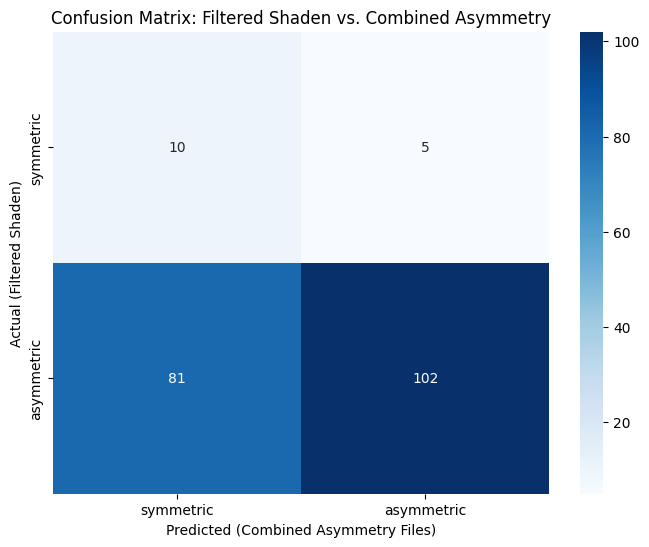


Number of common pairs: 198
Accuracy: 0.5656565656565656


In [ ]:
# @title confusion_matrix
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Specify file paths
shaden_file_path = '/content/drive/MyDrive/image_symmetry_project/ground_truth.csv'
combined_file_path = '/content/drive/MyDrive/image_symmetry_project/asymmetry_results.csv'

# Step 2: Load the CSV files
shaden_df = pd.read_csv(shaden_file_path)
combined_df = pd.read_csv(combined_file_path)

# Step 3: Print column names to debug
print("Columns in shaden_df:", shaden_df.columns.tolist())
print("Columns in combined_df:", combined_df.columns.tolist())

# Step 4: Create pair keys
shaden_df['pair_key'] = shaden_df['left'] + '|' + shaden_df['right']
combined_df['pair_key'] = combined_df['left'] + '|' + combined_df['right']

# Handle duplicates in combined_df
combined_df = combined_df.drop_duplicates(subset='pair_key', keep='first')

# Step 5: Merge on pair_key (excluding 'source_file')
merged_df = pd.merge(
    shaden_df[['pair_key', 'symmetry']],
    combined_df[['pair_key', 'symmetry']],
    on='pair_key',
    suffixes=('_shaden', '_combined')
)

# Step 6: Extract actual and predicted symmetry values
actual = merged_df['symmetry_shaden']
predicted = merged_df['symmetry_combined']

# Step 7: Compute confusion matrix
labels = ['symmetric', 'asymmetric']
cm = confusion_matrix(actual, predicted, labels=labels)

# Print the confusion matrix
print("\nConfusion Matrix:")
print(f"Labels: {labels}")
print(cm)

# Step 8: Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix: Filtered Shaden vs. Combined Asymmetry')
plt.xlabel('Predicted (Combined Asymmetry Files)')
plt.ylabel('Actual (Filtered Shaden)')
plt.show()

# Step 9: Print statistics
print("\nNumber of common pairs:", len(merged_df))
print("Accuracy:", np.sum(np.diag(cm)) / np.sum(cm))

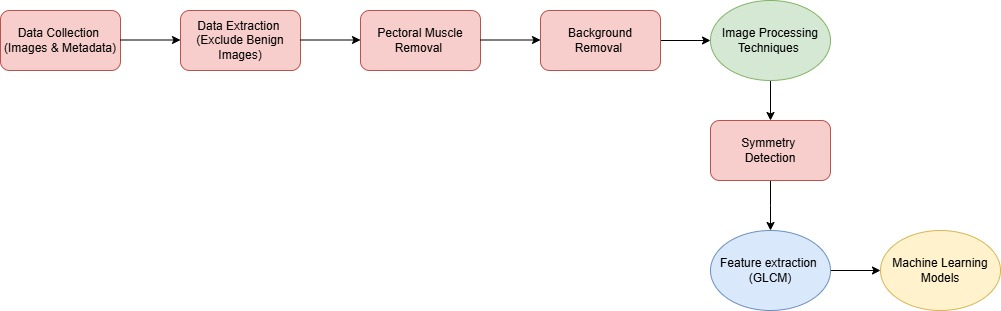

In [ ]:
# @title Feature_Extraction(GLCM)



# Load label CSV
df = pd.read_csv('/content/ground_truth.csv')
df[['patient_num', 'side', 'view']] = df['patient_id'].str.extract(r'(P\d+)_([LR])_DM_(CC|MLO)')

# Group by patient and view
pivot_df = df.pivot_table(index=['patient_num', 'view'], columns='side', values='patient_id', aggfunc='first').reset_index()

# GLCM feature extractor
def extract_glcm_features(image_path):
    img = imread(image_path, as_gray=True)
    img = (img * 255).astype(np.uint8)
    glcm = graycomatrix(img, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=256, symmetric=True, normed=True)
    features = {
        'contrast': graycoprops(glcm, 'contrast').mean(),
        'dissimilarity': graycoprops(glcm, 'dissimilarity').mean(),
        'homogeneity': graycoprops(glcm, 'homogeneity').mean(),
        'energy': graycoprops(glcm, 'energy').mean(),
        'correlation': graycoprops(glcm, 'correlation').mean()
    }
    return features

# Loop through pairs and compute symmetry
results = []
image_dir = "/content/drive/MyDrive/image_symmetry_project/Background_removal"
for _, row in tqdm(pivot_df.iterrows(), total=len(pivot_df)):
    left_img_name = row['L'] + '.jpg'
    right_img_name = row['R'] + '.jpg'
    left_path = os.path.join(image_dir, left_img_name)
    right_path = os.path.join(image_dir, right_img_name)

    if os.path.exists(left_path) and os.path.exists(right_path):
        left_feats = extract_glcm_features(left_path)
        right_feats = extract_glcm_features(right_path)

        # Calculate absolute differences between left and right features
        diff_feats = {f'diff_{k}': abs(left_feats[k] - right_feats[k]) for k in left_feats}

        results.append({
            'patient_num': row['patient_num'],
            'view': row['view'],
            'left_img': left_img_name,
            'right_img': right_img_name,
            **diff_feats
        })

# Create DataFrame of results
diff_df = pd.DataFrame(results)

# Merge original label info
merged = df.pivot_table(index=['patient_num', 'view'], columns='side', values='label', aggfunc='first').reset_index()
merged.columns.name = None
merged = merged.rename(columns={'L': 'label_left', 'R': 'label_right'})

# Merge with extracted features
final_df = pd.merge(diff_df, merged, on=['patient_num', 'view'], how='left')

# Define symmetry label
def define_symmetry(row):
    return 1 if row['label_left'].lower() == 'normal' and row['label_right'].lower() == 'normal' else 0

final_df['symmetry_label'] = final_df.apply(define_symmetry, axis=1)

# Identify difference columns
diff_cols = [col for col in final_df.columns if col.startswith('diff_')]

100%|██████████| 198/198 [01:19<00:00,  2.50it/s]


Target counts before SMOTE:
symmetry_label
0    183
1     15
Name: count, dtype: int64

Target counts after SMOTE (training set):
symmetry_label
1    62
0    48
Name: count, dtype: int64


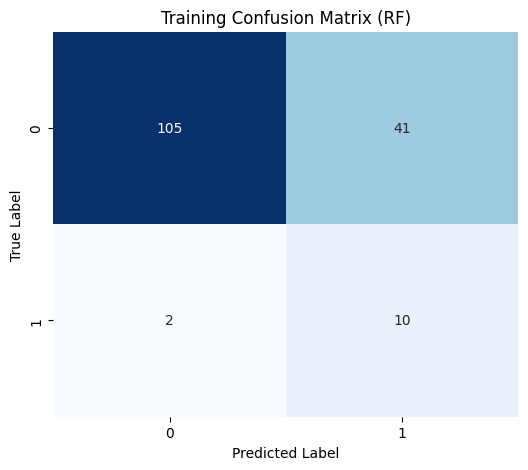


Training (RF) Confusion Matrix:
[[105  41]
 [  2  10]]

Training (RF) Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.72      0.83       146
           1       0.20      0.83      0.32        12

    accuracy                           0.73       158
   macro avg       0.59      0.78      0.57       158
weighted avg       0.92      0.73      0.79       158



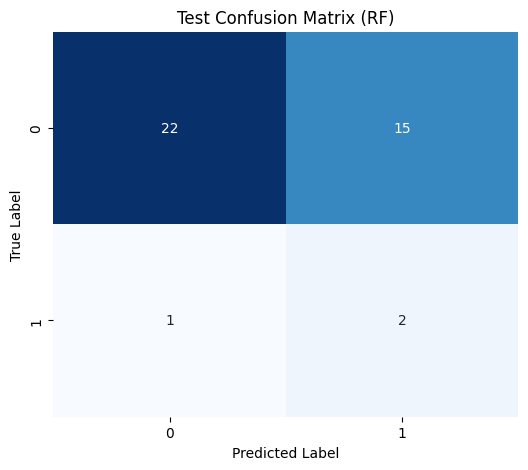


Test (RF) Confusion Matrix:
[[22 15]
 [ 1  2]]

Test (RF) Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.59      0.73        37
           1       0.12      0.67      0.20         3

    accuracy                           0.60        40
   macro avg       0.54      0.63      0.47        40
weighted avg       0.89      0.60      0.69        40



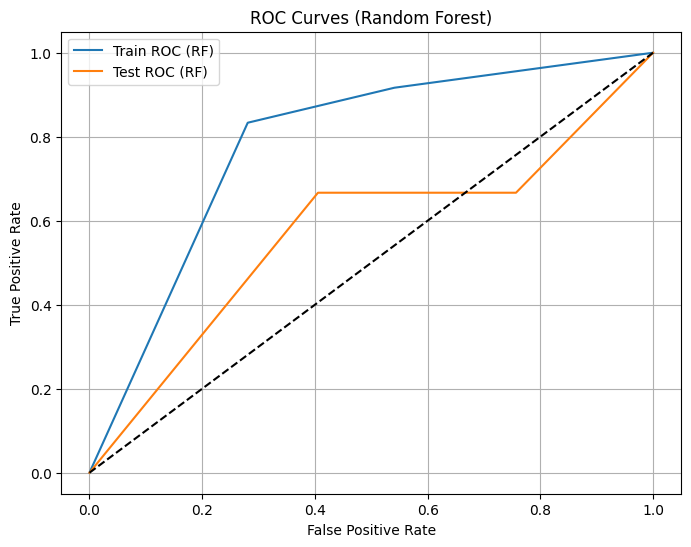


Feature Importance:
              Feature  Importance
0       diff_contrast    0.510337
1  diff_dissimilarity    0.292592
2    diff_homogeneity    0.087719
4    diff_correlation    0.066618
3         diff_energy    0.042735


In [ ]:
# @title Random Forest



# Prepare features and labels
X = final_df[diff_cols]
y = final_df['symmetry_label']

# Print target counts before SMOTE
print("Target counts before SMOTE:")
print(y.value_counts())

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTEENN to training data
smote = SMOTEENN(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Print target counts after SMOTE
print("\nTarget counts after SMOTE (training set):")
print(pd.Series(y_train_smote).value_counts())

# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=2, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train_smote, y_train_smote)

# Predict probabilities for ROC curve
y_train_pred_proba = rf_classifier.predict_proba(X_train)[:, 1]
y_test_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

# Predict labels
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()  # Display the plot in the notebook
    return cm

# Display confusion matrix and classification report
def display_metrics(y_true, y_pred, title):
    print(f"\n{title} Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    print(f"\n{title} Classification Report:")
    print(classification_report(y_true, y_pred))

# Plot and display metrics
train_cm = plot_confusion_matrix(y_train, y_train_pred, 'Training Confusion Matrix (RF)')
display_metrics(y_train, y_train_pred, 'Training (RF)')

test_cm = plot_confusion_matrix(y_test, y_test_pred, 'Test Confusion Matrix (RF)')
display_metrics(y_test, y_test_pred, 'Test (RF)')

# Plot ROC curve
train_fpr, train_tpr, _ = roc_curve(y_train, y_train_pred_proba, pos_label=1)
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_pred_proba, pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(train_fpr, train_tpr, label='Train ROC (RF)')
plt.plot(test_fpr, test_tpr, label='Test ROC (RF)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()  # Display the ROC curve in the notebook

# Print feature importance
feature_importance = pd.DataFrame({
    'Feature': diff_cols,
    'Importance': rf_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

=== Training Classification Report ===
              precision    recall  f1-score   support

           0       0.80      0.60      0.69       146
           1       0.68      0.85      0.76       146

    accuracy                           0.73       292
   macro avg       0.74      0.73      0.72       292
weighted avg       0.74      0.73      0.72       292

=== Training Confusion Matrix ===
[[ 88  58]
 [ 22 124]]

=== Test Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.46      0.63        37
           1       0.13      1.00      0.23         3

    accuracy                           0.50        40
   macro avg       0.57      0.73      0.43        40
weighted avg       0.93      0.50      0.60        40

=== Test Confusion Matrix ===
[[17 20]
 [ 0  3]]


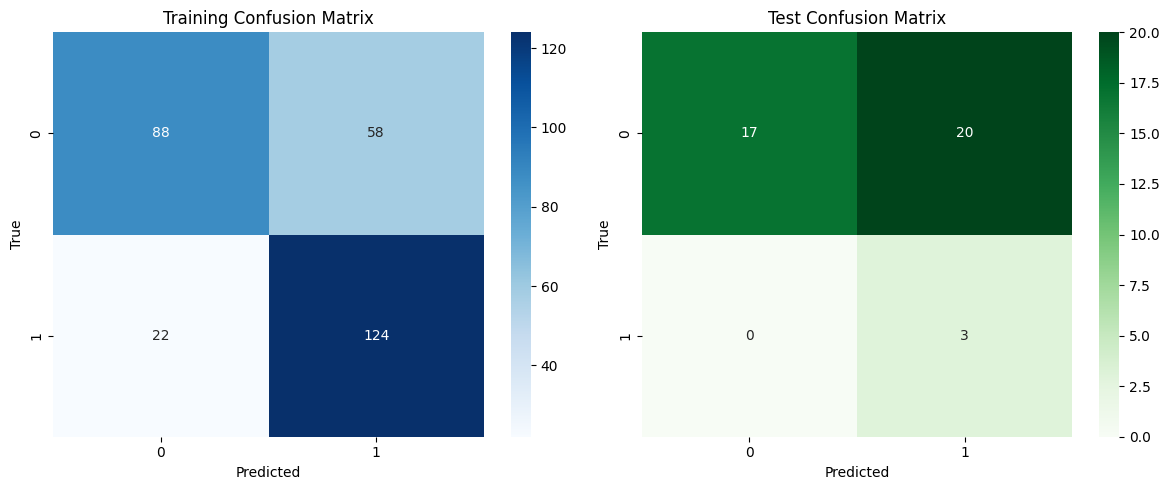

In [ ]:
# @title Logistic Regression

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
# Build Logistic Regression model
logreg = LogisticRegression(random_state=42, max_iter=50, solver='liblinear',C = 1e10,class_weight='balanced')# penalty='l2', C=0.08)
logreg.fit(X_train_smote, y_train_smote)

# ==== Evaluate on Training Set ====
y_train_pred = logreg.predict(X_train_smote)
print("=== Training Classification Report ===")
print(classification_report(y_train_smote, y_train_pred))

print("=== Training Confusion Matrix ===")
train_cm = confusion_matrix(y_train_smote, y_train_pred)
print(train_cm)

# ==== Evaluate on Test Set ====
y_test_pred = logreg.predict(X_test)
print("\n=== Test Classification Report ===")
print(classification_report(y_test, y_test_pred))

print("=== Test Confusion Matrix ===")
test_cm = confusion_matrix(y_test, y_test_pred)
print(test_cm)

# Optional: Plot confusion matrices
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Training Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(test_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Test Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()


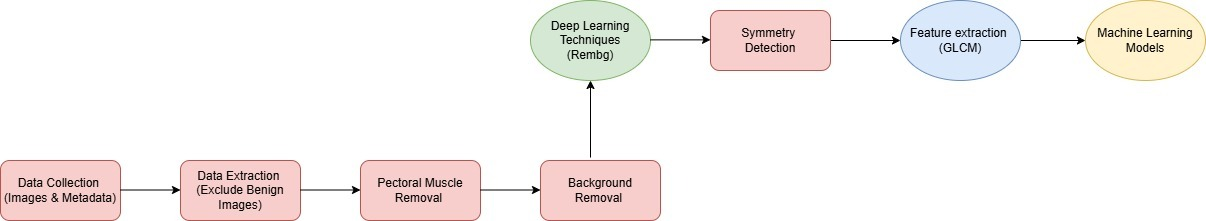

In [ ]:
# @title Remove background using Rembg
import os
from rembg import remove
from PIL import Image
import glob

# Directories
input_dir = "/content/drive/MyDrive/image_symmetry_project/paired_images"
output_dir = "/content/drive/MyDrive/Image_processing_project/rembg_white_output_fff/"

os.makedirs(output_dir, exist_ok=True)
image_files = glob.glob(os.path.join(input_dir, "*.*"))

def remove_bg_with_white_background(input_path, output_path):
    try:
        # Open image
        input_image = Image.open(input_path)

        # Remove background (returns RGBA with transparent bg)
        output_image = remove(input_image)

        # Create white background
        white_bg = Image.new('RGB', output_image.size, (255, 255, 255))

        # Paste the foreground image (using alpha channel as mask)
        white_bg.paste(output_image, (0, 0), output_image)

        # Save as JPEG (or keep PNG if preferred)
        if output_path.lower().endswith(('.jpg', '.jpeg')):
            white_bg = white_bg.convert('RGB')

        white_bg.save(output_path)
        print(f"Success: {output_path}")

    except Exception as e:
        print(f"Error processing {input_path}: {str(e)}")

# Process all images
for image_path in image_files:
    filename = os.path.basename(image_path)

    # Keep original extension or force JPEG/PNG
    output_path = os.path.join(output_dir, filename)

    # Optional: Force specific format
    # output_path = os.path.join(output_dir, os.path.splitext(filename)[0] + ".jpg")

    remove_bg_with_white_background(image_path, output_path)

print("All images processed with white background!")

100%|███████████████████████████████████████| 176M/176M [00:00<00:00, 29.9GB/s]


Success: /content/drive/MyDrive/Image_processing_project/rembg_white_output_fff/P100_R_DM_CC.jpg
Success: /content/drive/MyDrive/Image_processing_project/rembg_white_output_fff/P100_L_DM_CC.jpg
Success: /content/drive/MyDrive/Image_processing_project/rembg_white_output_fff/P101_R_DM_CC.jpg
Success: /content/drive/MyDrive/Image_processing_project/rembg_white_output_fff/P101_L_DM_CC.jpg
Success: /content/drive/MyDrive/Image_processing_project/rembg_white_output_fff/P102_L_DM_CC.jpg
Success: /content/drive/MyDrive/Image_processing_project/rembg_white_output_fff/P102_R_DM_CC.jpg
Success: /content/drive/MyDrive/Image_processing_project/rembg_white_output_fff/P103_R_DM_CC.jpg
Success: /content/drive/MyDrive/Image_processing_project/rembg_white_output_fff/P103_L_DM_CC.jpg
Success: /content/drive/MyDrive/Image_processing_project/rembg_white_output_fff/P105_L_DM_CC.jpg
Success: /content/drive/MyDrive/Image_processing_project/rembg_white_output_fff/P105_R_DM_CC.jpg
Success: /content/drive/MyDriv

In [ ]:
# @title Feature_extraction(GLCM)

# Load label CSV
df = pd.read_csv('/content/ground_truth.csv')
df[['patient_num', 'side', 'view']] = df['patient_id'].str.extract(r'(P\d+)_([LR])_DM_(CC|MLO)')

# Group by patient and view
pivot_df = df.pivot_table(index=['patient_num', 'view'], columns='side', values='patient_id', aggfunc='first').reset_index()

# GLCM feature extractor
def extract_glcm_features(image_path):
    img = imread(image_path, as_gray=True)
    img = (img * 255).astype(np.uint8)
    glcm = graycomatrix(img, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=256, symmetric=True, normed=True)
    features = {
        'contrast': graycoprops(glcm, 'contrast').mean(),
        'dissimilarity': graycoprops(glcm, 'dissimilarity').mean(),
        'homogeneity': graycoprops(glcm, 'homogeneity').mean(),
        'energy': graycoprops(glcm, 'energy').mean(),
        'correlation': graycoprops(glcm, 'correlation').mean()
    }
    return features

# Loop through pairs and compute symmetry
results = []
image_dir = '/content/drive/MyDrive/Image_processing_project/filtered_rembg_white_output_fff'
for _, row in tqdm(pivot_df.iterrows(), total=len(pivot_df)):
    left_img_name = row['L'] + '.jpg'
    right_img_name = row['R'] + '.jpg'
    left_path = os.path.join(image_dir, left_img_name)
    right_path = os.path.join(image_dir, right_img_name)

    if os.path.exists(left_path) and os.path.exists(right_path):
        left_feats = extract_glcm_features(left_path)
        right_feats = extract_glcm_features(right_path)

        # Calculate absolute differences between left and right features
        diff_feats = {f'diff_{k}': abs(left_feats[k] - right_feats[k]) for k in left_feats}

        results.append({
            'patient_num': row['patient_num'],
            'view': row['view'],
            'left_img': left_img_name,
            'right_img': right_img_name,
            **diff_feats
        })

# Create DataFrame of results
diff_df = pd.DataFrame(results)

# Merge original label info
merged = df.pivot_table(index=['patient_num', 'view'], columns='side', values='label', aggfunc='first').reset_index()
merged.columns.name = None
merged = merged.rename(columns={'L': 'label_left', 'R': 'label_right'})

# Merge with extracted features
final_df = pd.merge(diff_df, merged, on=['patient_num', 'view'], how='left')

# Define symmetry label
def define_symmetry(row):
    return 1 if row['label_left'].lower() == 'normal' and row['label_right'].lower() == 'normal' else 0

final_df['symmetry_label'] = final_df.apply(define_symmetry, axis=1)

# Identify difference columns
diff_cols = [col for col in final_df.columns if col.startswith('diff_')]

100%|██████████| 198/198 [01:10<00:00,  2.80it/s]


Target counts before SMOTE:
symmetry_label
0    183
1     15
Name: count, dtype: int64

Target counts after SMOTE (training set):
symmetry_label
1    60
0    52
Name: count, dtype: int64


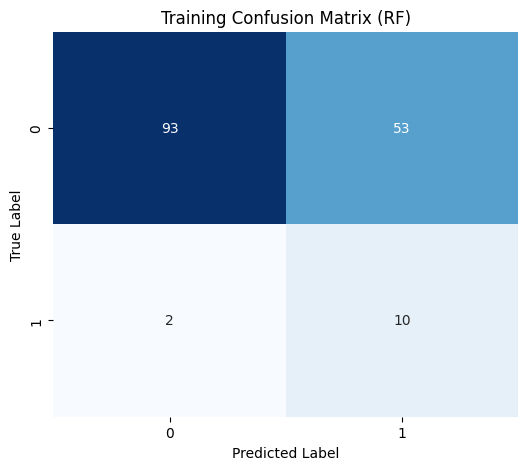


Training (RF) Confusion Matrix:
[[93 53]
 [ 2 10]]

Training (RF) Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.64      0.77       146
           1       0.16      0.83      0.27        12

    accuracy                           0.65       158
   macro avg       0.57      0.74      0.52       158
weighted avg       0.92      0.65      0.73       158



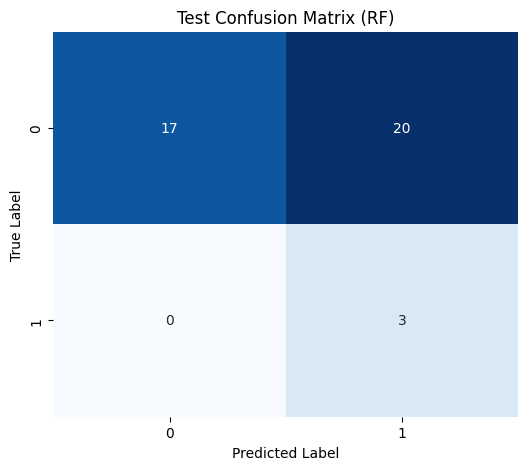


Test (RF) Confusion Matrix:
[[17 20]
 [ 0  3]]

Test (RF) Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.46      0.63        37
           1       0.13      1.00      0.23         3

    accuracy                           0.50        40
   macro avg       0.57      0.73      0.43        40
weighted avg       0.93      0.50      0.60        40



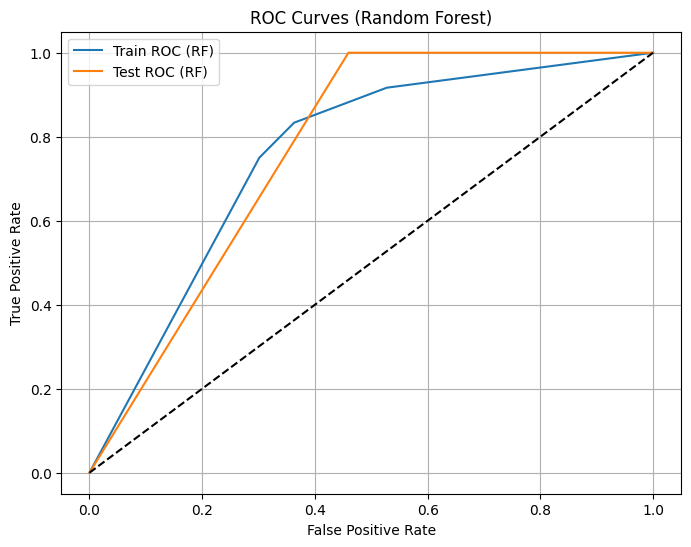


Feature Importance:
              Feature  Importance
0       diff_contrast    0.474757
1  diff_dissimilarity    0.418520
2    diff_homogeneity    0.053373
4    diff_correlation    0.029418
3         diff_energy    0.023932


In [ ]:
# @title Random forest

# Prepare features and labels
X = final_df[diff_cols]
y = final_df['symmetry_label']

# Print target counts before SMOTE
print("Target counts before SMOTE:")
print(y.value_counts())

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTEENN to training data
smote = SMOTEENN(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Print target counts after SMOTE
print("\nTarget counts after SMOTE (training set):")
print(pd.Series(y_train_smote).value_counts())

# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=3, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train_smote, y_train_smote)

# Predict probabilities for ROC curve
y_train_pred_proba = rf_classifier.predict_proba(X_train)[:, 1]
y_test_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

# Predict labels
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()  # Display the plot in the notebook
    return cm

# Display confusion matrix and classification report
def display_metrics(y_true, y_pred, title):
    print(f"\n{title} Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    print(f"\n{title} Classification Report:")
    print(classification_report(y_true, y_pred))

# Plot and display metrics
train_cm = plot_confusion_matrix(y_train, y_train_pred, 'Training Confusion Matrix (RF)')
display_metrics(y_train, y_train_pred, 'Training (RF)')

test_cm = plot_confusion_matrix(y_test, y_test_pred, 'Test Confusion Matrix (RF)')
display_metrics(y_test, y_test_pred, 'Test (RF)')

# Plot ROC curve
train_fpr, train_tpr, _ = roc_curve(y_train, y_train_pred_proba, pos_label=1)
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_pred_proba, pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(train_fpr, train_tpr, label='Train ROC (RF)')
plt.plot(test_fpr, test_tpr, label='Test ROC (RF)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()  # Display the ROC curve in the notebook

# Print feature importance
feature_importance = pd.DataFrame({
    'Feature': diff_cols,
    'Importance': rf_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

=== Training Classification Report ===
              precision    recall  f1-score   support

           0       0.78      0.57      0.66       146
           1       0.66      0.84      0.74       146

    accuracy                           0.71       292
   macro avg       0.72      0.71      0.70       292
weighted avg       0.72      0.71      0.70       292

=== Training Confusion Matrix ===
[[ 83  63]
 [ 23 123]]

=== Test Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.49      0.65        37
           1       0.14      1.00      0.24         3

    accuracy                           0.53        40
   macro avg       0.57      0.74      0.45        40
weighted avg       0.94      0.53      0.62        40

=== Test Confusion Matrix ===
[[18 19]
 [ 0  3]]


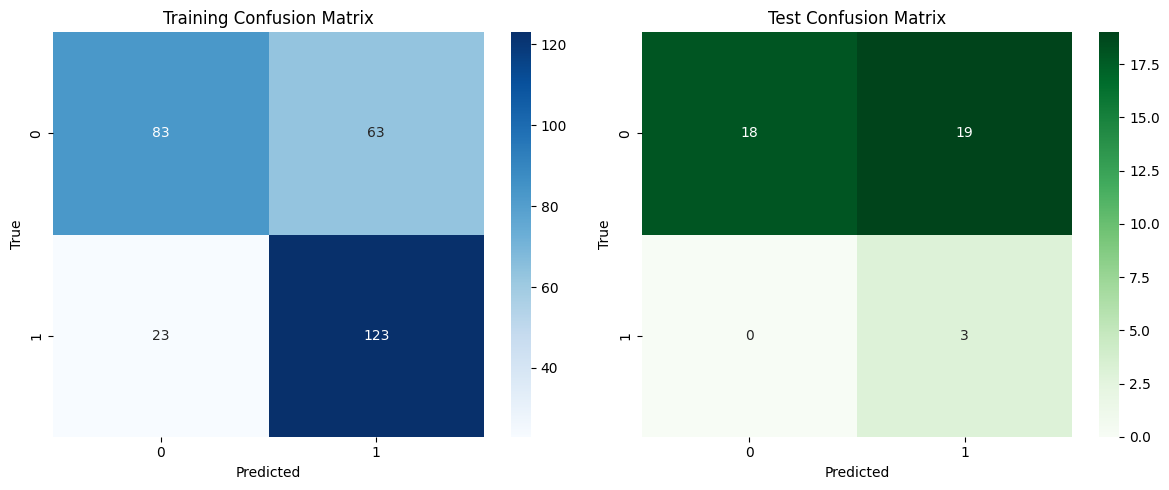

In [ ]:
# @title Logistic Regression
# Prepare features and labels
X = final_df[diff_cols]
y = final_df['symmetry_label']

# Print target counts before SMOTE
print("Target counts before SMOTE:")
print(y.value_counts())


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
# Build Logistic Regression model
logreg = LogisticRegression(random_state=42, max_iter=50, solver='liblinear',C = 1e10,class_weight='balanced')# penalty='l2', C=0.08)
logreg.fit(X_train_smote, y_train_smote)

# ==== Evaluate on Training Set ====
y_train_pred = logreg.predict(X_train_smote)
print("=== Training Classification Report ===")
print(classification_report(y_train_smote, y_train_pred))

print("=== Training Confusion Matrix ===")
train_cm = confusion_matrix(y_train_smote, y_train_pred)
print(train_cm)

# ==== Evaluate on Test Set ====
y_test_pred = logreg.predict(X_test)
print("\n=== Test Classification Report ===")
print(classification_report(y_test, y_test_pred))

print("=== Test Confusion Matrix ===")
test_cm = confusion_matrix(y_test, y_test_pred)
print(test_cm)

# Optional: Plot confusion matrices
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Training Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(test_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Test Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()


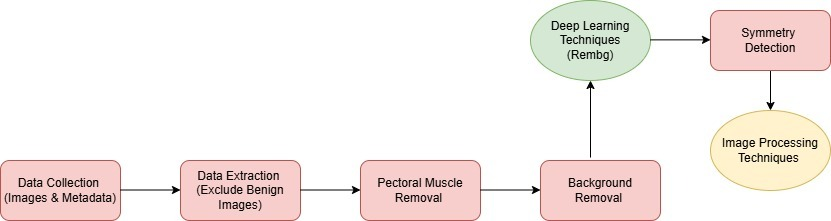

In [ ]:
# @title Symmetry detection after removing background using Rembg


def load_images(left_path, right_path):
    if not (os.path.exists(left_path) and os.path.exists(right_path)):
        raise FileNotFoundError(f"One or both image files not found: {left_path}, {right_path}")
    left_img = cv2.imread(left_path, cv2.IMREAD_GRAYSCALE)
    right_img = cv2.imread(right_path, cv2.IMREAD_GRAYSCALE)
    if left_img is None or right_img is None:
        raise ValueError("Failed to load one or both images.")
    if len(np.unique(left_img)) <= 2 and len(np.unique(right_img)) <= 2:
        print(f"Images {os.path.basename(left_path)} and {os.path.basename(right_path)} are already binary, skipping thresholding.")
    else:
        left_img = cv2.adaptiveThreshold(left_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY, 11, 2)
        right_img = cv2.adaptiveThreshold(right_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY, 11, 2)
    left_img = cv2.GaussianBlur(left_img, (3, 3), 0)
    right_img = cv2.GaussianBlur(right_img, (3, 3), 0)
    return left_img, right_img

def extract_control_points(img, sigma=15):
    try:
        mask = img > 0
        moments = cv2.moments(mask.astype(np.uint8))
        if moments['m00'] == 0:
            raise ValueError("Cannot compute center of mass.")
        center_mass = np.array([moments['m10'] / moments['m00'], moments['m01'] / moments['m00']])

        contours = find_contours(img, level=0.5)
        if not contours:
            raise ValueError("No contours found.")
        contour = max(contours, key=len)
        smoothed_x = gaussian_filter1d(contour[:, 1], sigma)
        smoothed_y = gaussian_filter1d(contour[:, 0], sigma)
        smoothed_contour = np.vstack((smoothed_y, smoothed_x)).T

        distances = np.linalg.norm(smoothed_contour - center_mass, axis=1)
        nipple_idx = np.argmax(distances)
        nipple = smoothed_contour[nipple_idx]

        left_edge_dist = smoothed_contour[:, 1]
        right_edge_dist = img.shape[1] - smoothed_contour[:, 1]
        left_corner_idx = np.argmin(left_edge_dist)
        right_corner_idx = np.argmin(right_edge_dist)
        corners = np.array([smoothed_contour[left角_idx], smoothed_contour[right_corner_idx]])
        return nipple, corners, mask, moments
    except Exception as e:
        print(f"Contour-based control point extraction failed: {e}. Using bounding box fallback.")
        mask = img > 0
        coords = np.where(mask)
        if not coords[0].size:
            raise ValueError("No non-zero pixels found in image.")
        top, bottom = np.min(coords[0]), np.max(coords[0])
        left, right = np.min(coords[1]), np.max(coords[1])
        nipple = np.array([(top + bottom) / 2, right])
        corners = np.array([[top, left], [bottom, left]])
        moments = cv2.moments(mask.astype(np.uint8))
        return nipple, corners, mask, moments

def align_images(left_img, right_img, left_control_points, right_control_points):
    try:
        if left_control_points is None or right_control_points is None:
            raise ValueError("Control points are None, using center-of-mass alignment.")
        nipple_left, corners_left, mask_left, moments_left = left_control_points
        nipple_right, corners_right, mask_right, moments_right = right_control_points
        C1_left, C3_left = corners_left
        C1_right, C3_right = corners_right
        C_m_left = (C1_left + C3_left) / 2
        C_m_right = (C1_right + C3_right) / 2
        baseline_left = C3_left - C1_left
        angle_left = np.arctan2(baseline_left[0], baseline_left[1]) * 180 / np.pi
        baseline_right = C3_right - C1_right
        angle_right = np.arctan2(baseline_right[0], baseline_right[1]) * 180 / np.pi
        rotation_angle = angle_left - angle_right

        right_img_rotated = rotate(right_img, rotation_angle, reshape=True, mode='nearest')
        right_img_rotated_binary = (right_img_rotated > 0).astype(np.uint8) * 255
        nipple_right_rot, corners_right_rot, _, _ = extract_control_points(right_img_rotated_binary)
        C_m_right_rot = (corners_right_rot[0] + corners_right_rot[1]) / 2
        translation = C_m_left - C_m_right_rot

        right_img_translated = np.roll(right_img_rotated, int(translation[0]), axis=0)
        right_img_translated = np.roll(right_img_translated, int(translation[1]), axis=1)

        h_left = np.linalg.norm(nipple_left - C_m_left)
        h_right = np.linalg.norm(nipple_right_rot - C_m_right_rot)
        scale_factor = h_left / (h_right + 1e-10)

        right_img_scaled = cv2.resize(right_img_translated, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_NEAREST)
        right_img_aligned = cv2.resize(right_img_scaled, (left_img.shape[1], left_img.shape[0]), interpolation=cv2.INTER_NEAREST)
        return right_img_aligned, False
    except Exception as e:
        print(f"Control point alignment failed: {e}. Using center-of-mass alignment.")
        mask_left = left_img > 0
        mask_right = right_img > 0
        moments_left = cv2.moments(mask_left.astype(np.uint8))
        moments_right = cv2.moments(mask_right.astype(np.uint8))
        if moments_left['m00'] == 0 or moments_right['m00'] == 0:
            raise ValueError("Cannot compute center of mass for one or both images.")
        center_left = np.array([moments_left['m10'] / moments_left['m00'], moments_left['m01'] / moments_left['m00']])
        center_right = np.array([moments_right['m10'] / moments_right['m00'], moments_right['m01'] / moments_right['m00']])
        translation = center_left - center_right
        right_img_translated = np.roll(right_img, int(translation[0]), axis=0)
        right_img_translated = np.roll(right_img_translated, int(translation[1]), axis=1)
        right_img_aligned = cv2.resize(right_img_translated, (left_img.shape[1], left_img.shape[0]), interpolation=cv2.INTER_NEAREST)
        return right_img_aligned, True

def normalize_image(img, mask=None):
    if mask is None:
        mask = img > 0
    mean = np.mean(img[mask]) if np.any(mask) else 0
    std = np.std(img[mask]) if np.any(mask) else 1
    normalized = np.zeros_like(img, dtype=np.float32)
    normalized[mask] = (img[mask] - mean) / (std + 1e-10)
    return normalized, mask

@jit(nopython=True)
def compute_window_stats(window, n):
    h_diff = np.abs(window[:, 1:] - window[:, :-1])
    v_diff = np.abs(window[1:, :] - window[:-1, :])
    diff = np.concatenate((h_diff.ravel(), v_diff.ravel()))
    hist, _ = np.histogram(diff, bins=256, range=(0, 255))
    p_j = hist / (n * n)
    sigma = np.sum(np.arange(256)**2 * p_j)

    total = 0.0
    count = 0
    for i in range(window.shape[0]):
        for j in range(window.shape[1]):
            if window[i, j] > 0:
                total += window[i, j]
                count += 1
    mu = total / count if count > 0 else 0.0
    return sigma, mu

def brightness_to_roughness(img, window_size=15):
    n = window_size
    sigma_W = np.zeros_like(img, dtype=np.float32)
    mu_W = np.zeros_like(img, dtype=np.float32)

    from numpy.lib.stride_tricks import sliding_window_view
    windows = sliding_window_view(img, (n, n))
    h, w = windows.shape[:2]

    def process_window(i, j):
        window = windows[i, j]
        if np.any(window > 0):
            sigma, mu = compute_window_stats(window, n)
            return i + n//2, j + n//2, sigma, mu
        return None

    results = Parallel(n_jobs=-1)(
        delayed(process_window)(i, j) for i in range(h) for j in range(w)
    )

    for result in results:
        if result is not None:
            i, j, sigma, mu = result
            sigma_W[i, j] = sigma
            mu_W[i, j] = mu

    q = mu_W**2 / (1 + sigma_W + 1e-10)
    return q

def brightness_difference(left_img, right_img, kernel_size=3):
    if left_img.shape != right_img.shape:
        raise ValueError(f"Image shapes mismatch: {left_img.shape} vs {right_img.shape}")
    kernel = np.ones((kernel_size, kernel_size), dtype=np.float32) / (kernel_size ** 2)
    conv_left = convolve(left_img, kernel, mode='constant')
    conv_right = convolve(right_img, kernel, mode='constant')
    B = np.abs(conv_left - conv_right)
    B = (B - np.min(B)) / (np.max(B) - np.min(B) + 1e-10)
    print(f"Debug: Mean Brightness Difference (B): {np.mean(B[B > 0]):.3f}")
    return B

def local_variance(img, var_size=15, norm_size=31):
    kernel_var = np.ones((var_size, var_size), dtype=np.float32)
    kernel_norm = np.ones((norm_size, norm_size), dtype=np.float32)

    img_sq = img**2
    conv_img_var = convolve(img, kernel_var, mode='constant')
    conv_img_sq_var = convolve(img_sq, kernel_var, mode='constant')
    conv_img_norm = convolve(img, kernel_norm, mode='constant')
    conv_img_sq_norm = convolve(img_sq, kernel_norm, mode='constant')

    var = conv_img_sq_var - conv_img_var**2 / (var_size**2)
    norm = conv_img_sq_norm - conv_img_norm**2 / (norm_size**2)

    result = var / (norm + 1e-10)
    print(f"Debug: Mean Local Variance: {np.mean(result[result > 0]):.3f}")
    return result

def brightness_to_roughness_difference(left_img, right_img):
    q_left = brightness_to_roughness(left_img)
    q_right = brightness_to_roughness(right_img)
    Q = np.abs(q_left - q_right)
    Q = (Q - np.min(Q)) / (np.max(Q) - np.min(Q) + 1e-10)
    print(f"Debug: Mean Brightness-to-Roughness Difference (Q): {np.mean(Q[Q > 0]):.3f}")
    return Q

def roughness_difference(left_img, right_img):
    v_left = local_variance(left_img)
    v_right = local_variance(right_img)
    R = np.abs(v_left - v_right)
    R = (R - np.min(R)) / (np.max(R) - np.min(R) + 1e-10)
    print(f"Debug: Mean Roughness Difference (R): {np.mean(R[R > 0]):.3f}")
    return R

def combine_asymmetry_measures(B, R, Q, D_left=None, D_right=None):
    A = B + R + Q
    print(f"Debug: Mean Combined Asymmetry (A): {np.mean(A[A > 0]):.3f}")
    return A

def detect_suspicious_areas(A, q1=1, q2=0.95, min_area=300, radius=20):
    T1 = np.percentile(A[A > 0], 100 - q1) if np.any(A > 0) else 0
    print(f"Debug: T1 Threshold: {T1:.3f}")
    potential_areas = A > T1
    labeled = label(potential_areas)
    regions = regionprops(labeled)
    suspicious_areas = []
    for region in regions:
        if region.area > min_area:
            centroid = region.centroid
            y, x = np.ogrid[:A.shape[0], :A.shape[1]]
            mask = (x - centroid[1])**2 + (y - centroid[0])**2 <= radius**2
            mean_response = np.mean(A[mask])
            suspicious_areas.append((centroid, mean_response))
    if not suspicious_areas:
        return []
    A_max = max([area[1] for area in suspicious_areas])
    final_areas = [area for area in suspicious_areas if area[1] > q2 * A_max]
    print(f"Debug: Number of Suspicious Areas: {len(final_areas)}")
    return final_areas

def analyze_symmetry(A, suspicious_areas, alignment_failed):
    mask = A > 0
    mean_asymmetry = np.mean(A[mask]) if np.any(mask) else 0
    symmetry_threshold = 0.3
    print("\nSymmetry Analysis:")
    if suspicious_areas:
        print("The breast images are asymmetric.")
        print("Reason(s):")
        print(f"- Suspicious areas were detected ({len(suspicious_areas)} areas), indicating a potential mass in one breast.")
        if mean_asymmetry >= symmetry_threshold:
            print(f"- The average asymmetry measure is high (mean A = {mean_asymmetry:.3f}), suggesting significant differences in brightness, roughness, or texture.")
        if alignment_failed:
            print("- Alignment issues were detected, which may contribute to the observed asymmetry.")
        return "asymmetric"
    else:
        print("The breast images are symmetric.")
        print("Reason: No suspicious areas were detected, indicating no mass in either breast.")
        if mean_asymmetry >= symmetry_threshold:
            print(f"Note: The average asymmetry measure is relatively high (mean A = {mean_asymmetry:.3f}), which may suggest minor differences due to natural variations or alignment issues, but no significant mass was detected.")
        if alignment_failed:
            print("Note: Alignment issues were detected, which may create minor artificial differences, but no significant mass was detected.")
        return "symmetric"

def process_image_pair(left_path, right_path):
    alignment_failed = False
    left_img, right_img = None, None
    try:
        left_img, right_img = load_images(left_path, right_path)
        nipple_left, corners_left, mask_left, moments_left = extract_control_points(left_img)
        nipple_right, corners_right, mask_right, moments_right = extract_control_points(right_img)
    except (FileNotFoundError, ValueError) as e:
        print(f"Error processing {os.path.basename(left_path)} and {os.path.basename(right_path)}: {e}")
        if left_img is None or right_img is None:
            print("Cannot proceed without valid images.")
            return None
        print("Using center-of-mass alignment due to control point extraction failure.")
        nipple_left, corners_left, mask_left, moments_left = None, None, None, None
        nipple_right, corners_right, mask_right, moments_right = None, None, None, None
        alignment_failed = True

    right_img_aligned, alignment_failed = align_images(
        left_img, right_img,
        (nipple_left, corners_left, mask_left, moments_left),
        (nipple_right, corners_right, mask_right, moments_right)
    )

    N_left, mask_left = normalize_image(left_img, mask_left)
    N_right, _ = normalize_image(right_img_aligned)
    B = brightness_difference(N_left, N_right)
    R = roughness_difference(N_left, N_right)
    Q = brightness_to_roughness_difference(N_left, N_right)
    A = combine_asymmetry_measures(B, R, Q)
    suspicious_areas = detect_suspicious_areas(A)
    symmetry_status = analyze_symmetry(A, suspicious_areas, alignment_failed)

    print(f"\nProcessed {os.path.basename(left_path)} and {os.path.basename(right_path)}")
    print(f"Detected {len(suspicious_areas)} suspicious areas.")
    print(f"Average Brightness Difference: {np.mean(B[B > 0]):.3f}")
    print(f"Average Roughness Difference: {np.mean(R[R > 0]):.3f}")
    print(f"Average Combined Asymmetry: {np.mean(A[A > 0]):.3f}")

    return {
        'left': os.path.basename(left_path),
        'right': os.path.basename(right_path),
        'symmetry': symmetry_status
    }

def main(directory, output_csv):
    left_images = glob.glob(os.path.join(directory, '*_L_DM_*.jpg'))
    results = []

    for left_path in left_images:
        left_name = os.path.basename(left_path)
        parts = left_name.split('_')
        if len(parts) < 4:
            print(f"Skipping invalid filename: {left_name}")
            continue
        patient_id = parts[0]
        view = parts[3].replace('.jpg', '')
        right_name = left_name.replace('_L_', '_R_')
        right_path = os.path.join(directory, right_name)

        if not os.path.exists(right_path):
            print(f"Missing right image for {left_name}: {right_name}")
            continue

        print(f"\nProcessing pair: {left_name} and {right_name}")
        result = process_image_pair(left_path, right_path)
        if result is not None:
            results.append(result)

    if results:
        df = pd.DataFrame(results, columns=['left', 'right', 'symmetry'])
        df.to_csv(output_csv, index=False)
        print(f"\nResults saved to {output_csv}")
        print(df)
    else:
        print("No valid image pairs processed.")

if __name__ == "__main__":
    directory = "/content/drive/MyDrive/Image_processing_project/split_folders/split_6"
    output_csv = "/content/drive/MyDrive/Image_processing_project/asymmetry_results_6_f.csv"
    main(directory, output_csv)


Processing pair: P276_L_DM_CC.jpg and P276_R_DM_CC.jpg
Contour-based control point extraction failed: name 'left角_idx' is not defined. Using bounding box fallback.
Contour-based control point extraction failed: name 'left角_idx' is not defined. Using bounding box fallback.
Contour-based control point extraction failed: name 'left角_idx' is not defined. Using bounding box fallback.
Debug: Mean Brightness Difference (B): 0.210
Debug: Mean Local Variance: 0.216
Debug: Mean Local Variance: 0.213
Debug: Mean Roughness Difference (R): 0.286
Debug: Mean Brightness-to-Roughness Difference (Q): 0.252
Debug: Mean Combined Asymmetry (A): 0.743
Debug: T1 Threshold: 2.306

Symmetry Analysis:
The breast images are symmetric.
Reason: No suspicious areas were detected, indicating no mass in either breast.
Note: The average asymmetry measure is relatively high (mean A = 0.743), which may suggest minor differences due to natural variations or alignment issues, but no significant mass was detected.

Proce

Columns in shaden_df: ['left', 'right', 'symmetry']
Columns in combined_df: ['left', 'right', 'symmetry']

Confusion Matrix:
Labels: ['symmetric', 'asymmetric']
[[ 6  5]
 [87 48]]


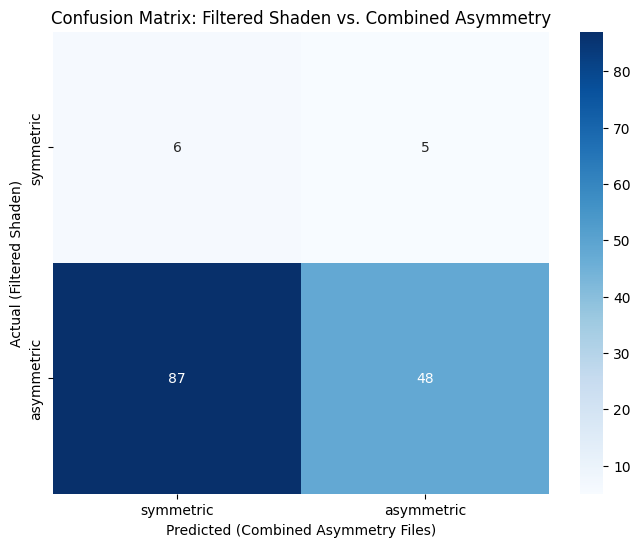


Number of common pairs: 146
Accuracy: 0.3698630136986301


In [ ]:
# @title Confusion Matrix
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Specify file paths
shaden_file_path = '/content/drive/MyDrive/conf_metrix/ground_truth.csv'
combined_file_path = '/content/drive/MyDrive/conf_metrix/rembg_asymmetry.csv'

# Step 2: Load the CSV files
shaden_df = pd.read_csv(shaden_file_path)
combined_df = pd.read_csv(combined_file_path)

# Print column names to confirm
print("Columns in shaden_df:", shaden_df.columns.tolist())
print("Columns in combined_df:", combined_df.columns.tolist())

# Step 3: Match pairs and extract symmetry values
shaden_df['pair_key'] = shaden_df['left'] + '|' + shaden_df['right']
combined_df['pair_key'] = combined_df['left'] + '|' + combined_df['right']

# Handle duplicates in combined_df
combined_df = combined_df.drop_duplicates(subset='pair_key', keep='first')

# Merge on pair_key
merged_df = pd.merge(
    shaden_df[['pair_key', 'symmetry']],
    combined_df[['pair_key', 'symmetry']],
    on='pair_key',
    suffixes=('_shaden', '_combined')
)

# Extract actual and predicted symmetry values
actual = merged_df['symmetry_shaden']
predicted = merged_df['symmetry_combined']

# Step 4: Compute confusion matrix
labels = ['symmetric', 'asymmetric']
cm = confusion_matrix(actual, predicted, labels=labels)

# Print the confusion matrix
print("\nConfusion Matrix:")
print(f"Labels: {labels}")
print(cm)

# Step 5: Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix: Filtered Shaden vs. Combined Asymmetry')
plt.xlabel('Predicted (Combined Asymmetry Files)')
plt.ylabel('Actual (Filtered Shaden)')
plt.show()

# Print statistics
print("\nNumber of common pairs:", len(merged_df))
print("Accuracy:", np.sum(np.diag(cm)) / np.sum(cm))

#Deep_learning

In [ ]:
# @title DL without rembg
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
from PIL import Image
import os

# --- 1. Custom Dataset ---
class PairedImageDataset(Dataset):
    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        left_img = Image.open(os.path.join(self.img_dir, row['left'])).convert("RGB")
        right_img = Image.open(os.path.join(self.img_dir, row['right'])).convert("RGB")

        # Combine left and right images side by side
        new_img = Image.new('RGB', (left_img.width + right_img.width, left_img.height))
        new_img.paste(left_img, (0, 0))
        new_img.paste(right_img, (left_img.width, 0))

        if self.transform:
            new_img = self.transform(new_img)

        label = int(row['label'])
        return new_img, label

# --- 2. Load & Prepare Data ---
csv_file = '/content/drive/MyDrive/conf_metrix/ground_truth.csv'
img_dir = '/content/drive/MyDrive/Image_processing_project/combined_images'
df = pd.read_csv(csv_file)

# Map 'symmetric' to 1 and 'asymmetric' to 0
df['label'] = df['symmetry'].str.strip().str.lower().map({'symmetric': 1, 'asymmetric': 0})

# Split into train/test
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# --- 3. Transforms ---
transform = transforms.Compose([
    transforms.Resize((224, 448)),  # Keep standard height, doubled width
    transforms.ToTensor(),
])

# --- 4. Dataset & Dataloader ---
train_dataset = PairedImageDataset(train_df, img_dir, transform)
test_dataset = PairedImageDataset(test_df, img_dir, transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# --- 5. Model ---
class SymmetryModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 2)

    def forward(self, x):
        return self.backbone(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SymmetryModel().to(device)

# --- 6. Training Setup ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
EPOCHS = 30
PATIENCE = 5
best_val_acc = 0
early_stop_counter = 0

# --- 7. Training Loop ---
for epoch in range(EPOCHS):
    model.train()
    correct = total = train_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total

    # Validation
    model.eval()
    correct = total = val_loss = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Early stopping logic
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

# --- 8. Final Evaluation ---
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred))


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 255MB/s]


Epoch 1 | Train Acc: 0.8987 | Val Acc: 0.9250
Epoch 2 | Train Acc: 0.9241 | Val Acc: 0.9250
Epoch 3 | Train Acc: 0.9304 | Val Acc: 0.9250
Epoch 4 | Train Acc: 0.9620 | Val Acc: 0.9250
Epoch 5 | Train Acc: 1.0000 | Val Acc: 0.9250
Epoch 6 | Train Acc: 1.0000 | Val Acc: 0.9000
Early stopping triggered.

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        37
           1       0.00      0.00      0.00         3

    accuracy                           0.93        40
   macro avg       0.46      0.50      0.48        40
weighted avg       0.86      0.93      0.89        40



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# @title DL with rembg
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
from PIL import Image
import os

# --- 1. Custom Dataset ---
class PairedImageDataset(Dataset):
    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        left_img = Image.open(os.path.join(self.img_dir, row['left'])).convert("RGB")
        right_img = Image.open(os.path.join(self.img_dir, row['right'])).convert("RGB")

        # Combine left and right images side by side
        new_img = Image.new('RGB', (left_img.width + right_img.width, left_img.height))
        new_img.paste(left_img, (0, 0))
        new_img.paste(right_img, (left_img.width, 0))

        if self.transform:
            new_img = self.transform(new_img)

        label = int(row['label'])
        return new_img, label

# --- 2. Load & Prepare Data ---
csv_file = '/content/drive/MyDrive/conf_metrix/ground_truth.csv'
img_dir = '/content/drive/MyDrive/Image_processing_project/combined_images'
df = pd.read_csv(csv_file)

# Clean and map labels
df['label'] = df['symmetry'].str.strip().str.lower().map({'symmetric': 1, 'asymmetric': 0})

# Train/test split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# --- 3. Transforms ---
transform = transforms.Compose([
    transforms.Resize((224, 448)),  # Height, Width (concatenated)
    transforms.ToTensor(),
])

# --- 4. Dataset & Dataloaders ---
train_dataset = PairedImageDataset(train_df, img_dir, transform)
test_dataset = PairedImageDataset(test_df, img_dir, transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# --- 5. Model ---
class SymmetryModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 2)

    def forward(self, x):
        return self.backbone(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SymmetryModel().to(device)

# --- 6. Class-Weighted Loss ---
# Calculate class weights manually
label_counts = train_df['label'].value_counts().to_dict()  # {0: ..., 1: ...}
total = sum(label_counts.values())
class_weights = torch.tensor([
    total / label_counts.get(0, 1),  # weight for class 0
    total / label_counts.get(1, 1)   # weight for class 1
]).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 30
PATIENCE = 5
best_val_acc = 0
early_stop_counter = 0

# --- 7. Training Loop ---
for epoch in range(EPOCHS):
    model.train()
    correct = total = train_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total

    # Validation
    model.eval()
    correct = total = val_loss = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

# --- 8. Final Evaluation ---
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, zero_division=0))


Epoch 1 | Train Acc: 0.9114 | Val Acc: 0.9250
Epoch 2 | Train Acc: 0.9810 | Val Acc: 0.9000
Epoch 3 | Train Acc: 0.9937 | Val Acc: 0.9250
Epoch 4 | Train Acc: 1.0000 | Val Acc: 0.9250
Epoch 5 | Train Acc: 1.0000 | Val Acc: 0.9250
Epoch 6 | Train Acc: 1.0000 | Val Acc: 0.8750
Early stopping triggered.

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        37
           1       0.00      0.00      0.00         3

    accuracy                           0.93        40
   macro avg       0.46      0.50      0.48        40
weighted avg       0.86      0.93      0.89        40

